In [2]:
%pylab
%matplotlib inline

import h5py
import pandas as pd
import os
import gc

#import plotly.express as px
from sklearn.preprocessing import MinMaxScaler,Normalizer,RobustScaler

import Helper_Basic as hbasic
hbasic.set_plot_prop()
plt.ion()

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


# Requirement for this script :

## Inputs :
1) H5/csv file with the mechanical data

2) AE catalog (csv) potentially with co-located mechanical data 

## Outputs :

1) Aligned, uniformally spaced, and time aggregated mechanical and AE rate/strain rate/work rate time series 

2) AE event catalog with data appended from the mechanical datasets (e.g. strain rate etc)

# Datafile with the raw deformation datasets & synchronised AE datasets 

a) Specify the path where the mechanical data is stored (in a h5 file)

b) Specify path to the AE data

In [3]:
path_data_folder = '../00_Data/Dry_Basalt_Ar/'
path_mechanical_data = path_data_folder+'dryargon_mechdata.csv'
path_AE_data = path_data_folder+'dryargon_events_with_mechdata.csv'
name_exp = 'Dry_Basalt_Argon'

## Location where the time series data (aggregated) is saved
path_to_save_out_time_series = '/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_' 
#######################################################################################
sample_length = 77.30


### Loading the Mechanical Data

In [4]:
data_def = pd.read_csv(path_mechanical_data)
data_def


,Disp_mm,Sig_diff_MPa,t_def,Strain_ax
0,2.95308,-8.79797,-105850,0.000000
1,2.95308,-8.79797,-105848,0.000000
2,2.95308,-8.79797,-105846,0.000000
3,2.95308,-8.79797,-105844,0.000000
4,2.95167,-8.79797,-105842,-0.000477
...,...,...,...,...
506683,3.92235,-8.79797,409680,0.328223
506684,3.72284,-8.79797,409681,0.260663
506685,3.52332,-8.79797,409682,0.193100
506686,3.32240,-8.79797,409683,0.125063


In [5]:
data_def = pd.read_csv(path_mechanical_data)
data_def['Strain_ax'] = data_def['Disp_mm']/sample_length 
data_def['date'] = np.datetime64('2021-09-01')+pd.to_timedelta(data_def['t_def'],unit='s')
data_def['time_hr'] = (data_def['date'] - data_def['date'].iloc[0])/ np.timedelta64(3600, 's')
#data_def = data_def.drop_duplicates('date', 'last')
data_def = data_def.set_index('date')


In [6]:
data_def['Time_Since_Step_1'] = (data_def['time_hr'] - 24.4329).clip(0)
data_def['Time_Since_Step_2'] = (data_def['time_hr'] - 47.101).clip(0)


In [7]:
dt = np.gradient(data_def.time_hr)
dt_resamp = np.nanmean(dt)
print(dt_resamp)

sampling_rate = int(dt_resamp*3600)
if sampling_rate == 0 :
    sampling_rate = 1    

0.0002826281766206337


In [8]:
new_data_def = data_def.resample(str(sampling_rate)+'s',closed='left', label='right').mean().ffill()

In [9]:
print(np.where(new_data_def['Disp_mm'].isna() == True)[0])

[]


In [10]:
new_data_def

,Disp_mm,Sig_diff_MPa,t_def,Strain_ax,time_hr,Time_Since_Step_1,Time_Since_Step_2
date,,,,,,,
2021-08-30 18:35:51,2.95308,-8.79797,-105850.0,0.038203,0.000000,0.000000,0.000000
2021-08-30 18:35:52,2.95308,-8.79797,-105850.0,0.038203,0.000000,0.000000,0.000000
2021-08-30 18:35:53,2.95308,-8.79797,-105848.0,0.038203,0.000556,0.000000,0.000000
2021-08-30 18:35:54,2.95308,-8.79797,-105848.0,0.038203,0.000556,0.000000,0.000000
2021-08-30 18:35:55,2.95308,-8.79797,-105846.0,0.038203,0.001111,0.000000,0.000000
...,...,...,...,...,...,...,...
2021-09-05 17:48:01,3.92235,-8.79797,409680.0,0.050742,143.202778,118.769878,96.101778
2021-09-05 17:48:02,3.72284,-8.79797,409681.0,0.048161,143.203056,118.770156,96.102056
2021-09-05 17:48:03,3.52332,-8.79797,409682.0,0.045580,143.203333,118.770433,96.102333


### Synchronised AE dataset Loading

In [11]:
data = pd.read_csv(path_AE_data)
data['Strain_ax'] = data['Disp_mm']/sample_length 

data['Disp_mm'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Sig_diff_MPa'].interpolate(method='linear',limit_area='inside',inplace=True)
data['Strain_ax'].interpolate(method='linear',limit_area='inside',inplace=True)
#data['Temp'].interpolate(method='linear',limit_area='inside',inplace=True)
#data['date'] = pd.to_datetime(data['timestamp'])
data['date'] = np.datetime64('2021-09-01')+pd.to_timedelta(data['timestamp'],unit='s')


In [12]:
### Drop AE events with no mechanical data
drop_data_indx = np.where(data['Disp_mm'].isna() != True)[0]
data = data.loc[data.index.isin(drop_data_indx),:].reset_index()

data['time_hr'] = (data['date'] - data_def.index[0])/ np.timedelta64(3600, 's')
data['count'] = np.ones(data['time_hr'].values.shape)
offset_hr = data['time_hr'].min()
data['time_hr'] = data['time_hr'] - offset_hr
new_data_def['time_hr'] = new_data_def['time_hr'] - offset_hr
new_data = data.set_index('date')

In [13]:
data

,index,evID,timestamp,Disp_mm,Sig_diff_MPa,Strain_ax,date,time_hr,count
0,0,450362,450,3.71010,9.870210,0.047996,2021-09-01 00:07:30,0.000000,1.0
1,1,516565,516,3.71859,11.013200,0.048106,2021-09-01 00:08:36,0.018333,1.0
2,2,547714,547,3.72425,11.775100,0.048179,2021-09-01 00:09:07,0.026944,1.0
3,3,549371,549,3.72283,11.775100,0.048161,2021-09-01 00:09:09,0.027500,1.0
4,4,550745,550,3.72283,11.775100,0.048161,2021-09-01 00:09:10,0.027778,1.0
...,...,...,...,...,...,...,...,...,...
1680,1680,258300650,258300,6.19624,5.679400,0.080158,2021-09-03 23:45:00,71.625000,1.0
1681,1681,258301493,258301,6.19624,5.679400,0.080158,2021-09-03 23:45:01,71.625278,1.0
1682,1682,258305617,258305,6.19482,5.679400,0.080140,2021-09-03 23:45:05,71.626389,1.0
1683,1683,258307101,258307,6.19482,5.679400,0.080140,2021-09-03 23:45:07,71.626944,1.0


Text(0, 0.5, 'Orange (AE cumulative), Blue (Diff Stress)')

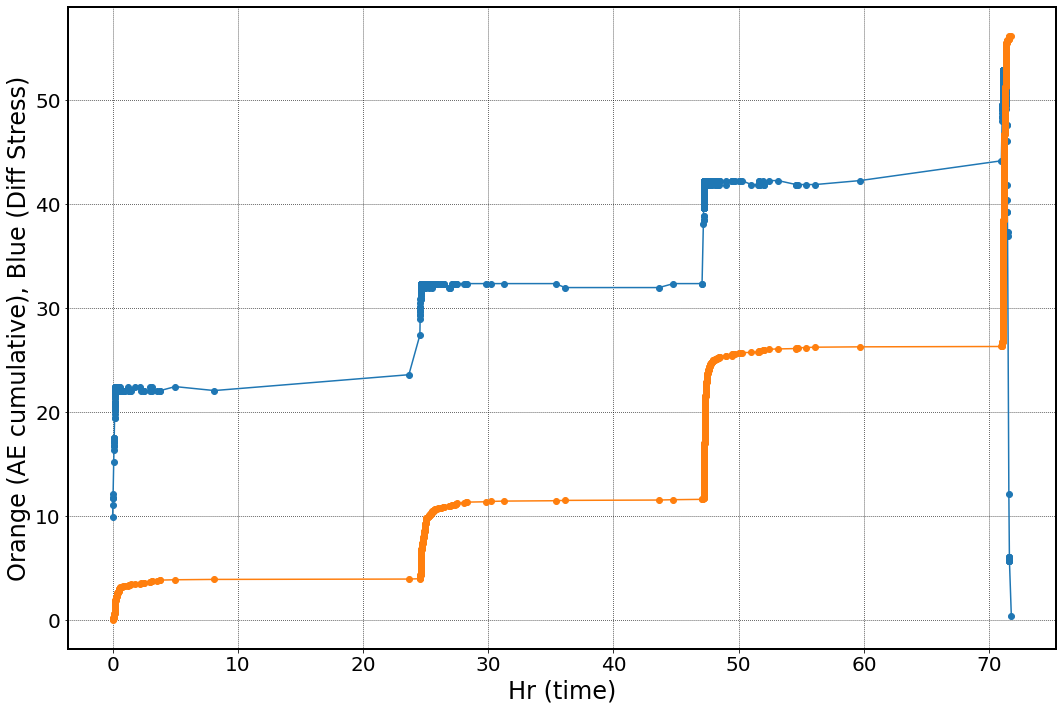

In [14]:
plt.plot(data.time_hr,data.Sig_diff_MPa,'o-')
plt.plot(data.time_hr,np.cumsum(data['count'])/30,'o-')
plt.xlabel('Hr (time)')
plt.ylabel('Orange (AE cumulative), Blue (Diff Stress)')

## Check Synchronization

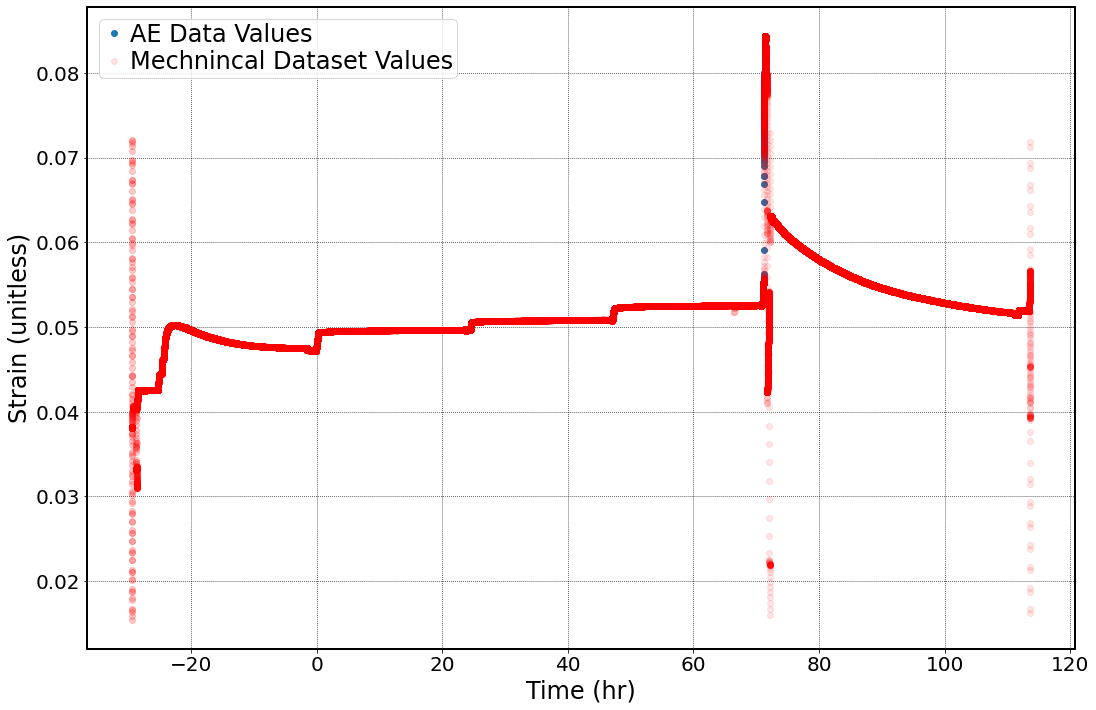

In [15]:
plt.plot(new_data.time_hr,new_data.Strain_ax,'o',label='AE Data Values')
plt.plot(new_data_def.time_hr,new_data_def.Strain_ax,'ro',alpha=0.1,label='Mechnincal Dataset Values') 
#plt.xlim([30,60])
plt.xlabel('Time (hr)')
plt.ylabel('Strain (unitless)')
plt.legend()
#plt.ylim([0.,0.01])

Text(0.5, 0, 'Time (Date)')

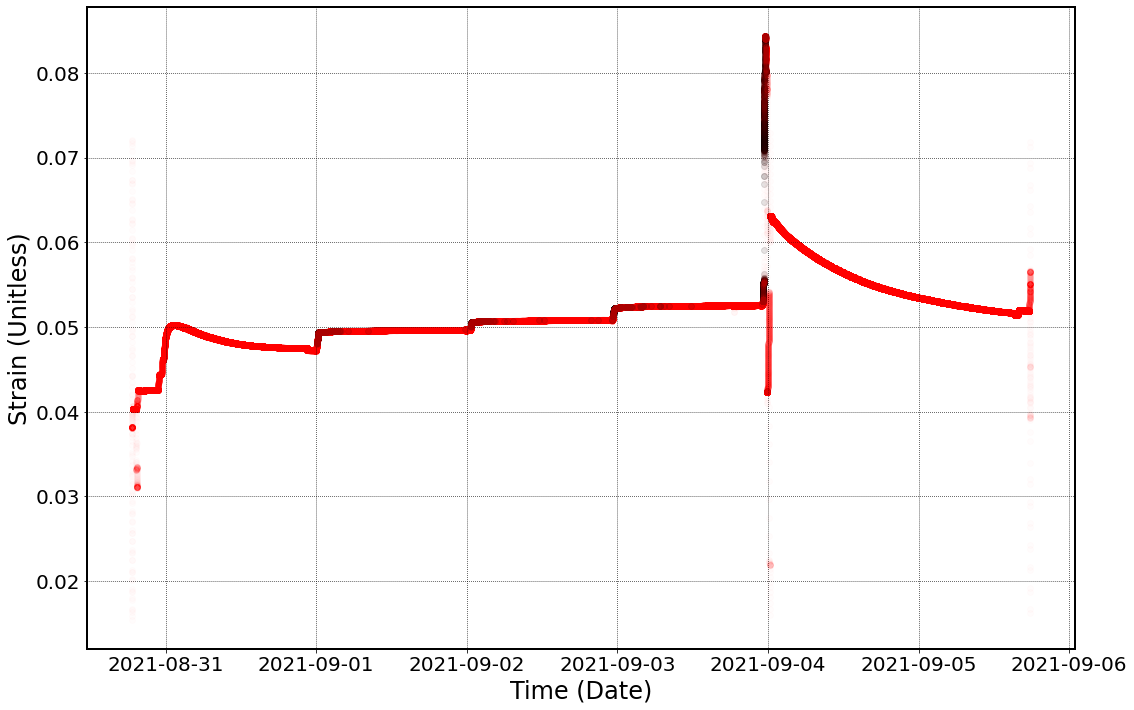

In [16]:
plt.plot(new_data.index,new_data['Strain_ax'],'ko',alpha=.1)
plt.plot(data_def.index,data_def['Strain_ax'],'ro',alpha=0.01)
plt.ylabel('Strain (Unitless)')
plt.xlabel('Time (Date)')
#plt.xlim([np.datetime64('2020-02-19'),np.datetime64('2020-02-20')])
#plt.ylim([0,0.01])
#plt.tight_layout()

### Final Cleaned, Aligned Datasets 

In [17]:
### AE dataset & deformation data with time as the index
# new_data -- AE Data
# new_data_def -- Deformation Data (resampled)

#### Time region cutoff to ensure that both the datasets are comparable

In [18]:
start_date = np.max([new_data_def.index.values[0],new_data.index.values[0]])
end_date = np.min([new_data_def.index.values[-1],new_data.index.values[-1]])
print(f'{start_date}, {end_date}')

2021-09-01T00:07:30.000000000, 2021-09-03T23:54:17.000000000


## Analysis Parts :

a) Make a catalog for the AE data with strain rate etc (extended mechanical catalog)

b) Data plotting with different time aggregations & saving time series for analysis

### Make a time aggregated dataset (mechanical data) to merge with the event catalog

In [19]:
time_window = 60  ## Aggregation Time Window in seconds

In [20]:
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
new_AE_data = pd.merge_asof(new_data, new_data_def_Sampl, left_index = True, right_index = True,
                            direction='forward',tolerance=pd.Timedelta(seconds=time_window),
             suffixes =['','_1min'])
## Note that when we aggregate, the time label is assigned to the end of the time window (right). So, for an event,
#  the relevant data is in the next timestamp (or not relevant - so we have a tolerance) ..

In [21]:
new_AE_data.columns

Index(['index', 'evID', 'timestamp', 'Disp_mm', 'Sig_diff_MPa', 'Strain_ax',
       'time_hr', 'count', 'Disp_mm_1min', 'Sig_diff_MPa_1min', 't_def',
       'Strain_ax_1min', 'time_hr_1min', 'Time_Since_Step_1',
       'Time_Since_Step_2', 'AE_rate_count', 'strain_rate', 'stress_rate',
       'AE_rate_count_rate', 'Sig_AE_rate', 'strain_rate_AE_rate',
       'strain_AE_rate', 'Sig_strain', 'Sig_strain_rate',
       'Strain_strain_rate'],
      dtype='object')

In [22]:
new_AE_data

,index,evID,timestamp,Disp_mm,Sig_diff_MPa,Strain_ax,time_hr,count,Disp_mm_1min,Sig_diff_MPa_1min,...,AE_rate_count,strain_rate,stress_rate,AE_rate_count_rate,Sig_AE_rate,strain_rate_AE_rate,strain_AE_rate,Sig_strain,Sig_strain_rate,Strain_strain_rate
date,,,,,,,,,,,,,,,,,,,,,
2021-09-01 00:07:30,0,450362,450,3.71010,9.870210,0.047996,0.000000,1.0,3.710759,10.060708,...,1.0,0.000000,0.000000,0.0,0.002691,0.005458,0.001281,0.038003,0.161897,0.077090
2021-09-01 00:08:36,1,516565,516,3.71859,11.013200,0.048106,0.018333,1.0,3.718117,11.083013,...,1.0,0.000095,1.022306,0.0,0.002854,0.005486,0.001303,0.040997,0.172631,0.078789
2021-09-01 00:09:07,2,547714,547,3.72425,11.775100,0.048179,0.026944,1.0,3.724835,12.079900,...,4.0,0.000087,0.996887,3.0,0.012057,0.021933,0.005290,0.043947,0.182213,0.079946
2021-09-01 00:09:09,3,549371,549,3.72283,11.775100,0.048161,0.027500,1.0,3.724835,12.079900,...,4.0,0.000087,0.996887,3.0,0.012057,0.021933,0.005290,0.043947,0.182213,0.079946
2021-09-01 00:09:10,4,550745,550,3.72283,11.775100,0.048161,0.027778,1.0,3.724835,12.079900,...,4.0,0.000087,0.996887,3.0,0.012057,0.021933,0.005290,0.043947,0.182213,0.079946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-03 23:45:00,1680,258300650,258300,6.19624,5.679400,0.080158,71.625000,1.0,6.217038,7.082685,...,5.0,-0.000794,-2.355749,5.0,0.011067,0.026129,0.043194,0.210803,0.127519,0.497729
2021-09-03 23:45:01,1681,258301493,258301,6.19624,5.679400,0.080158,71.625278,1.0,6.175932,4.701539,...,4.0,-0.000532,-2.381146,-1.0,0.007327,0.021209,0.034073,0.172020,0.107078,0.497962
2021-09-03 23:45:05,1682,258305617,258305,6.19482,5.679400,0.080140,71.626389,1.0,6.175932,4.701539,...,4.0,-0.000532,-2.381146,-1.0,0.007327,0.021209,0.034073,0.172020,0.107078,0.497962


In [23]:
new_AE_data.to_csv(path_AE_data.split('.csv')[0]+'_AppendedMechanical_'+time_agg+'.csv')

In [26]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)

%matplotlib qt
plt.plot(new_AE_data['time_hr'],new_AE_data['Sig_diff_MPa'],'o')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Sig_diff_MPa'],'k-',alpha=0.2)
plt.plot(new_AE_data['time_hr'],new_AE_data['Strain_ax']*3000,'ro')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Strain_ax']*3000,'r-',alpha=0.2)
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['AE_rate_count']*3,'b-')

Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')


In [25]:
%matplotlib qt
plt.plot(new_AE_data['time_hr'],new_AE_data['Sig_diff_MPa'],'o')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Sig_diff_MPa'],'k-',alpha=0.2)
plt.plot(new_AE_data['time_hr'],new_AE_data['Strain_ax']*3000,'ro')
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['Strain_ax']*3000,'r-',alpha=0.2)
plt.plot(new_data_def_Sampl['time_hr'],new_data_def_Sampl['AE_rate_count']*3,'b-')

In [23]:
del new_AE_data

## Plotting/Analysis of the data with AE rate etc 

In [25]:
try  :
    os.mkdir(path_to_save_out_time_series+name_exp)
except :
    print(f' {path_to_save_out_time_series+name_exp} Exists')
    
try  :
    os.mkdir(path_to_save_out_time_series+name_exp+'/'+time_agg)
except :
    print(f"{path_to_save_out_time_series+name_exp+'/'+time_agg} Exists")

path_save_file = path_to_save_out_time_series+name_exp+'/'+time_agg

 /home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Dry_Basalt_Argon Exists
/home/tmittal/Causality/Basalt_Data/dataforcausalitytests_Dry_Basalt_Argon/1min Exists


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'Time_Since_Step_1', 'Time_Since_Step_2', 'AE_rate_count',
       'strain_rate', 'stress_rate', 'AE_rate_count_rate', 'Sig_AE_rate',
       'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt_Argon Exists
Index value for the stress steps:  [   1   12 1477 2836 3379]
Time(hr) for the stress steps:  [1.625000e-02 2.461625e+01 4.726625e+01 5.631625e+01]


45452

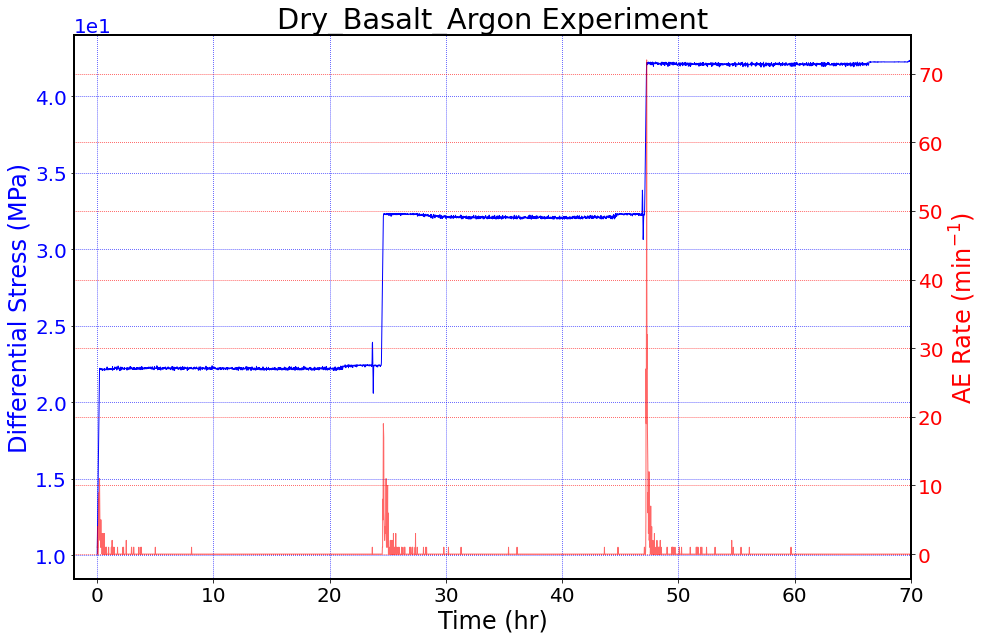

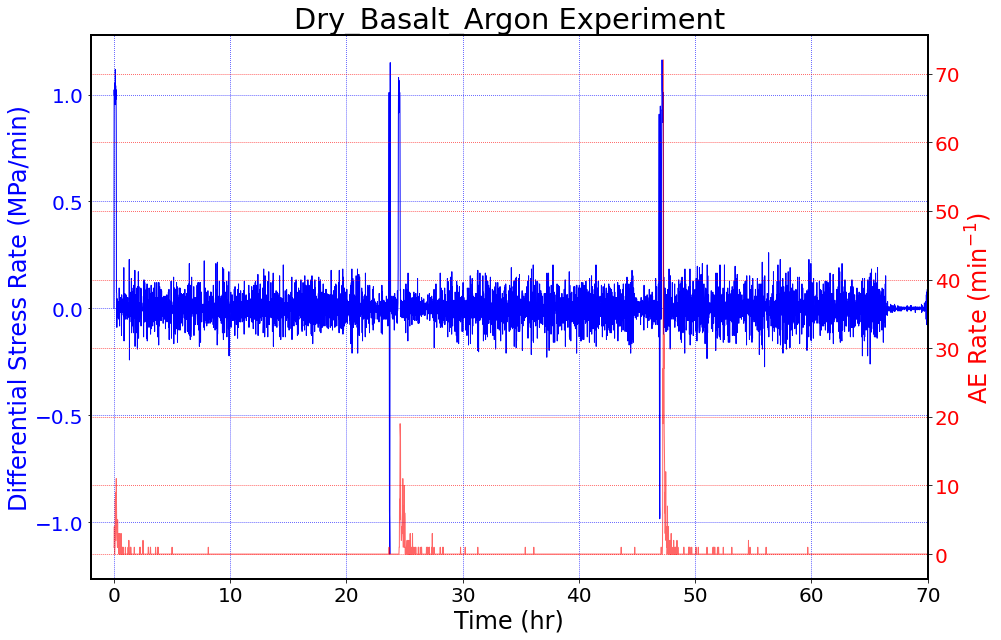

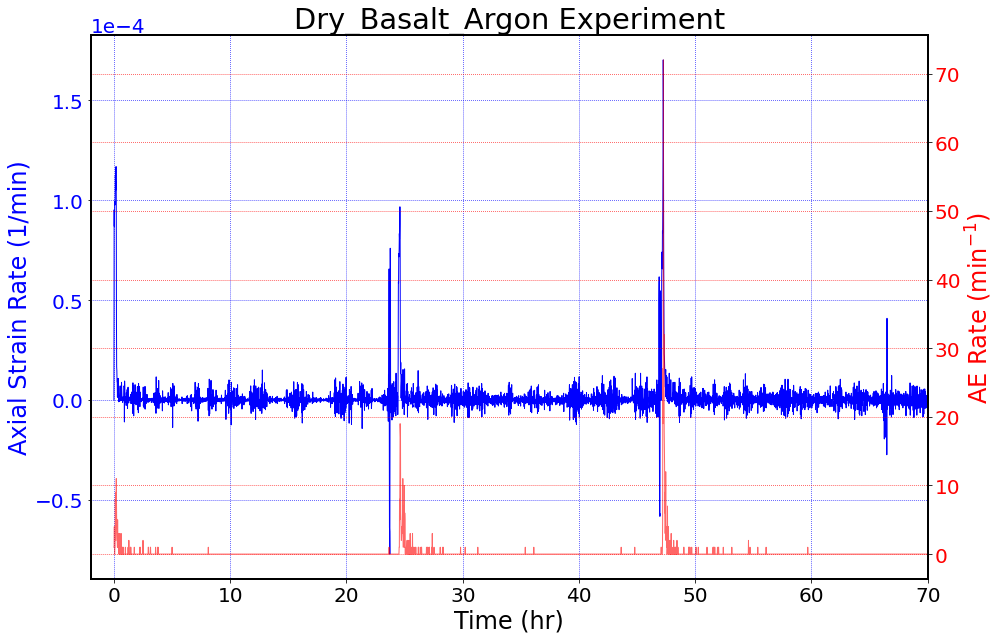

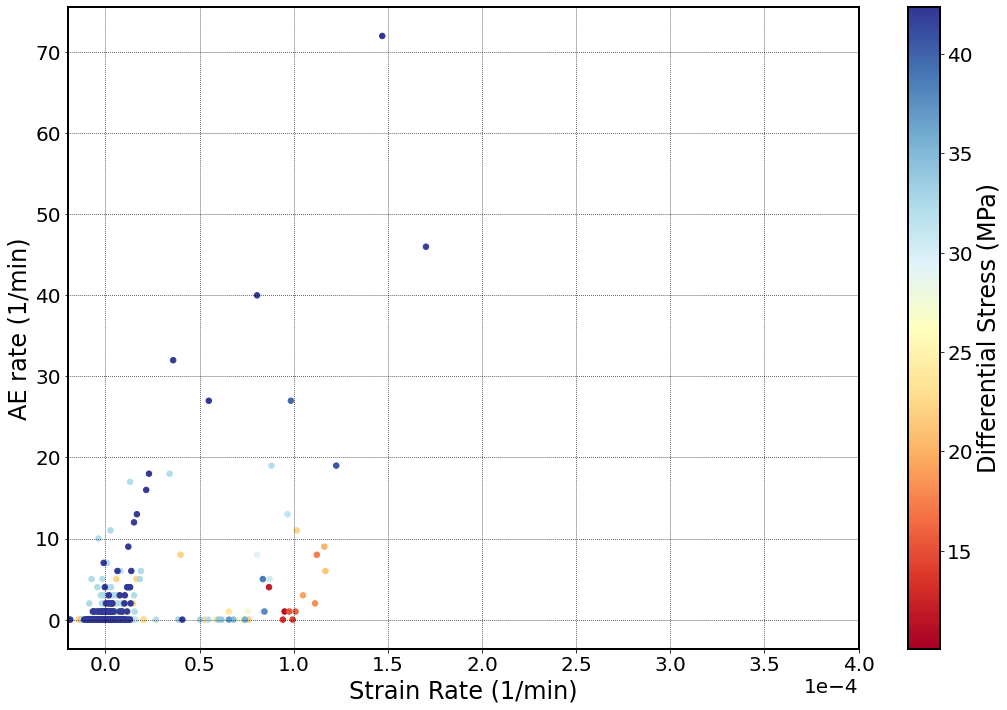

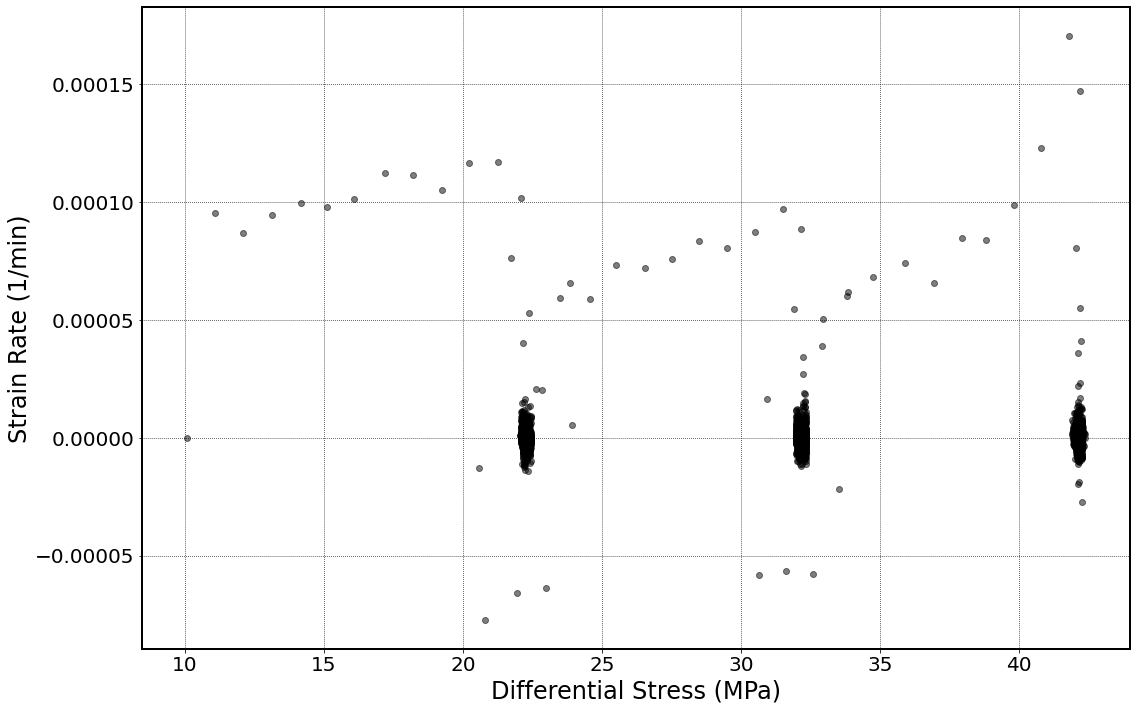

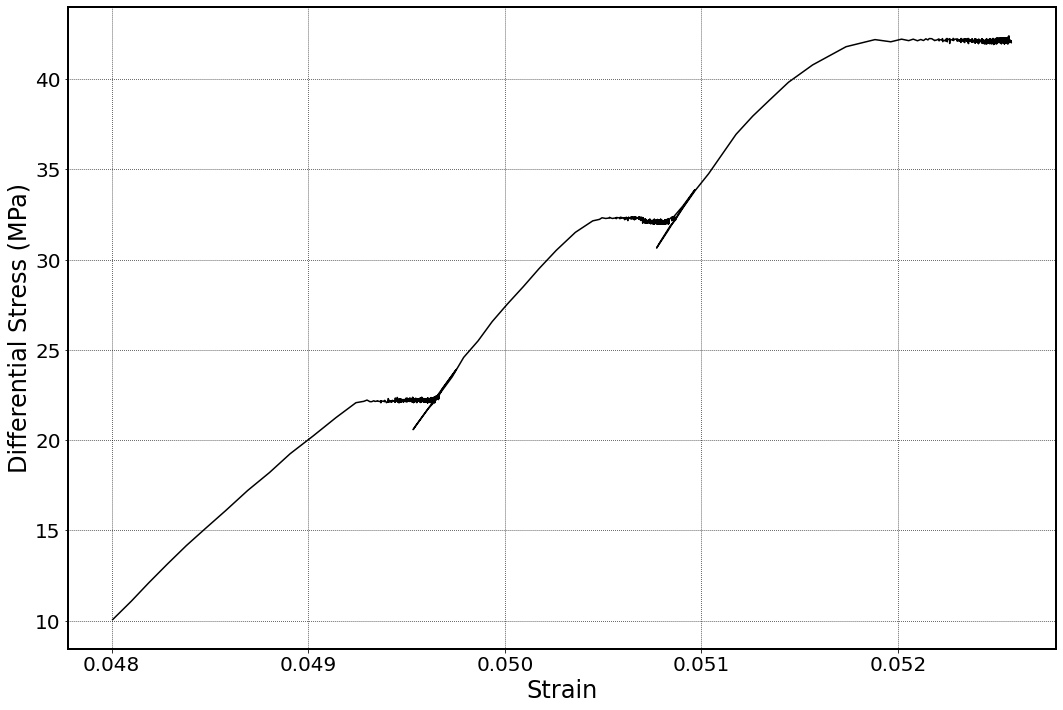

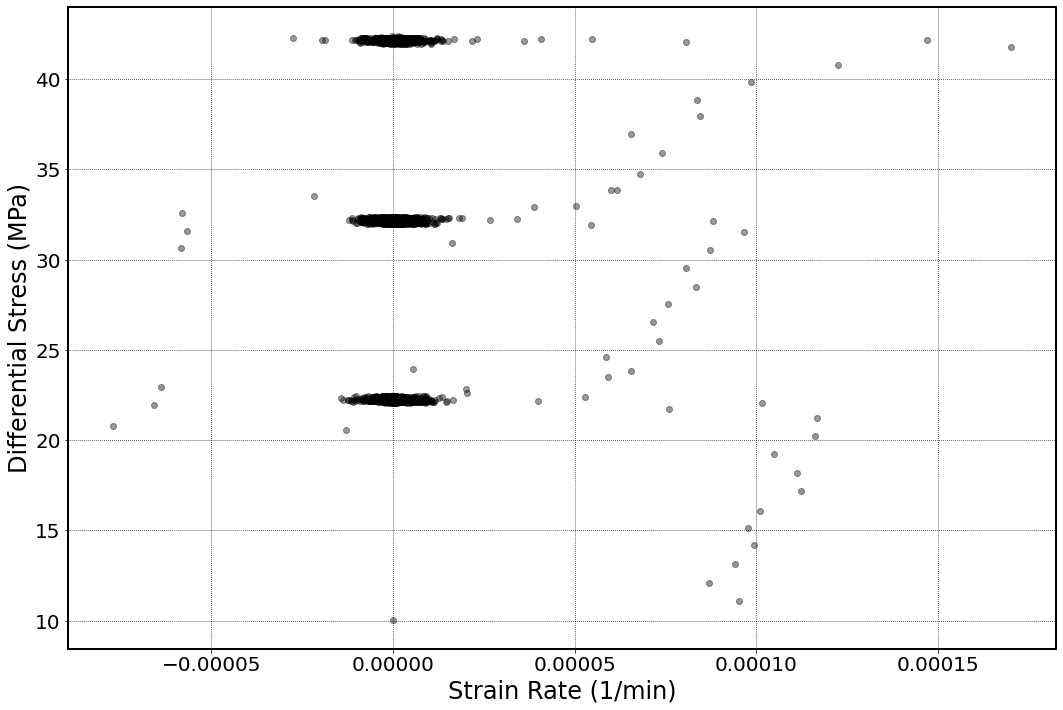

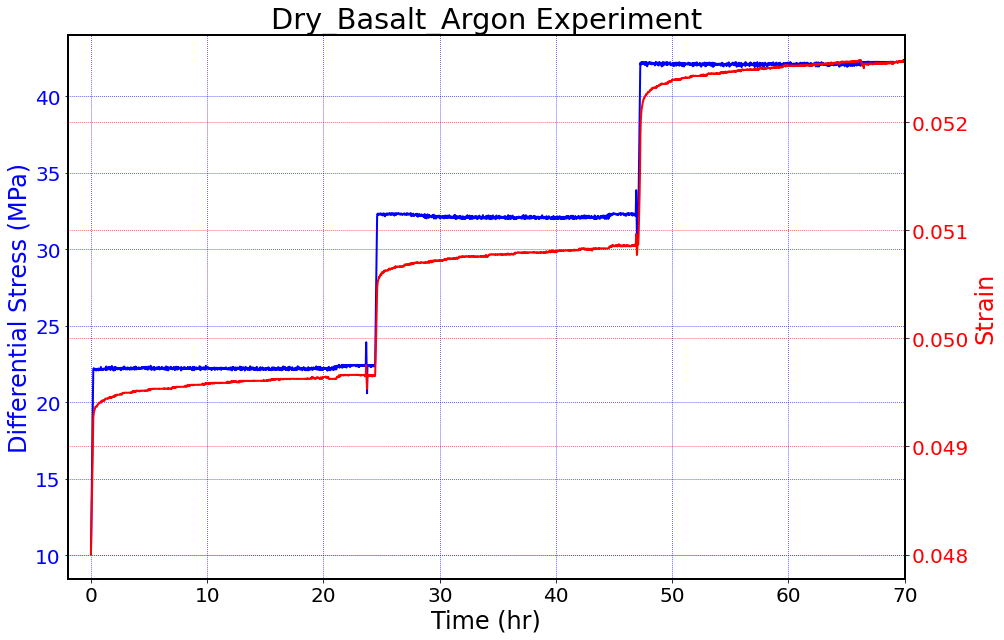

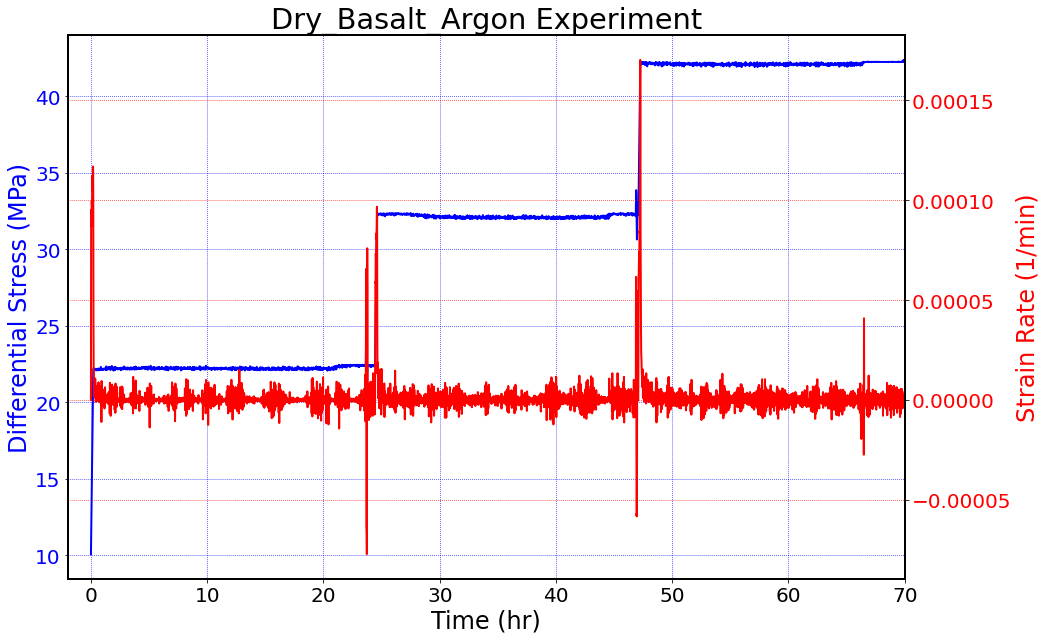

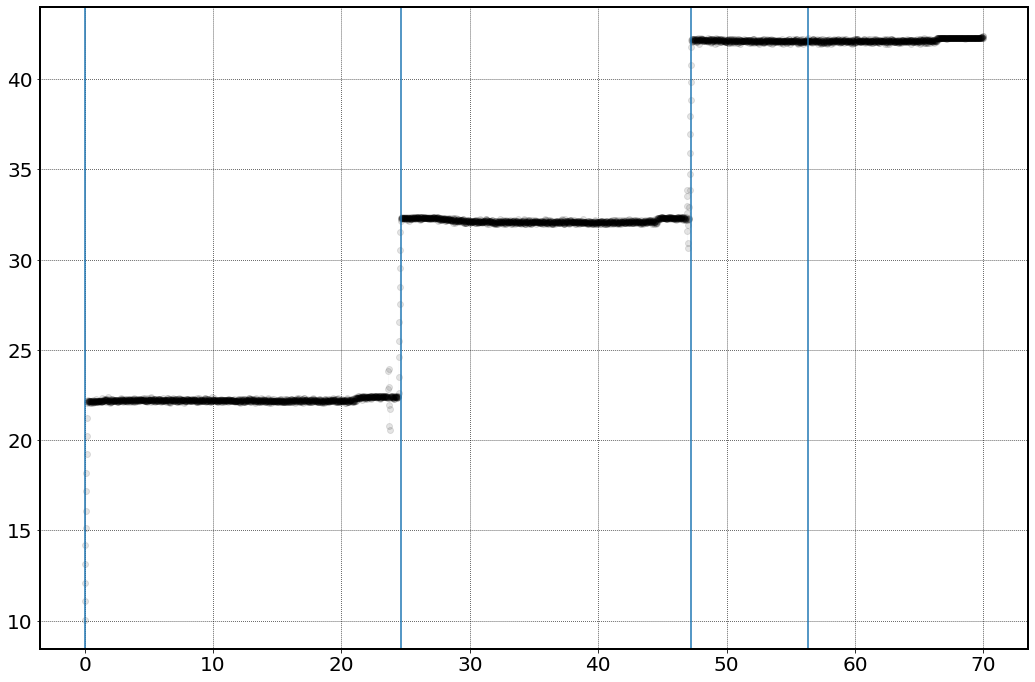

In [27]:
time_window = 60
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=70.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,Temperature=False,max_val=70)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt_Argon Exists
Index value for the stress steps:  [   1    7  739 1418]
Time(hr) for the stress steps:  [2.45833333e-02 2.46245833e+01 4.72579167e+01]


45450

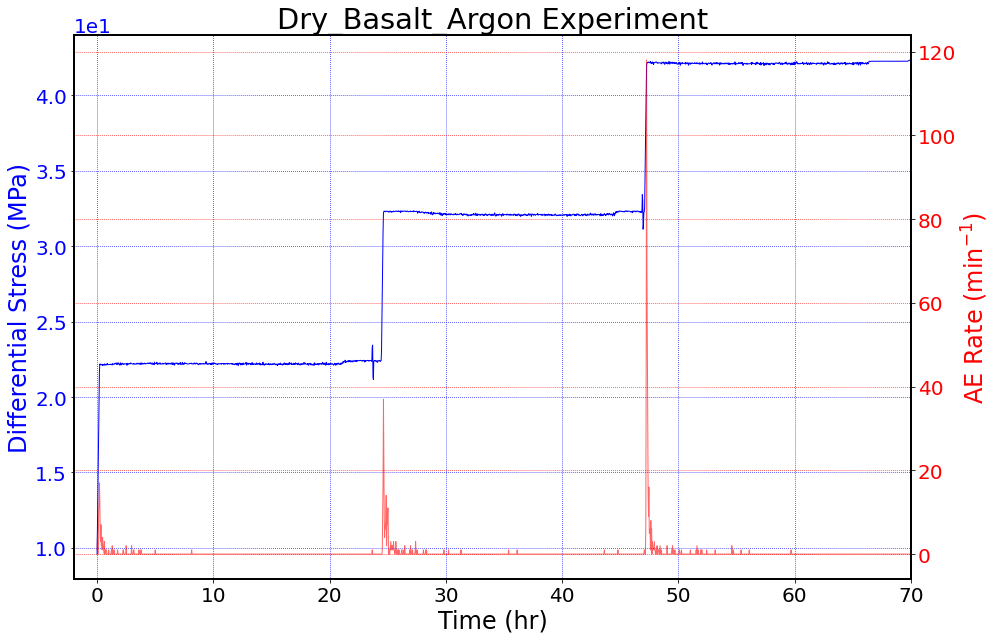

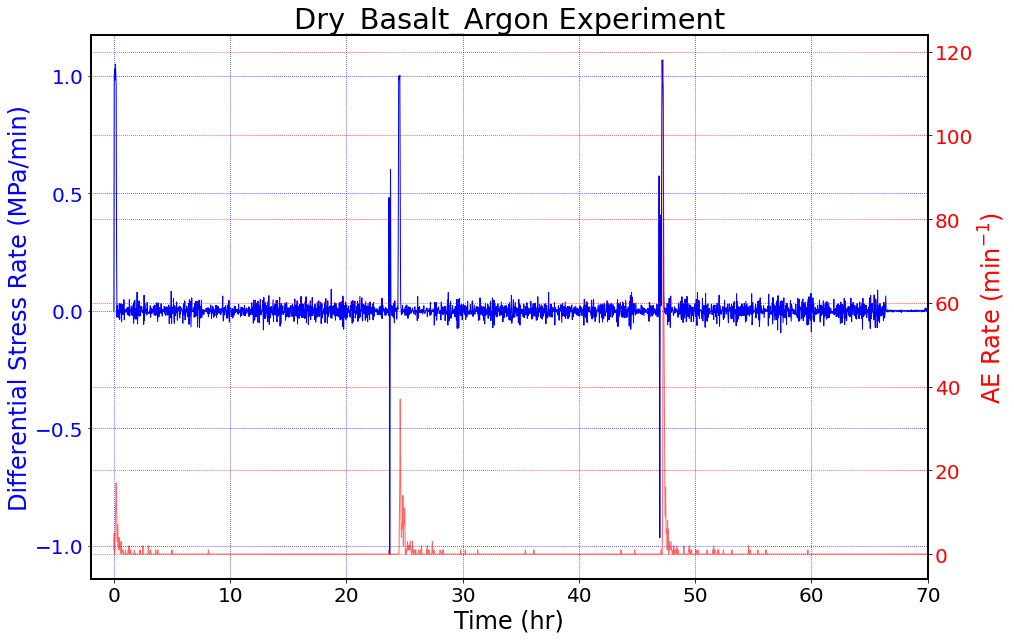

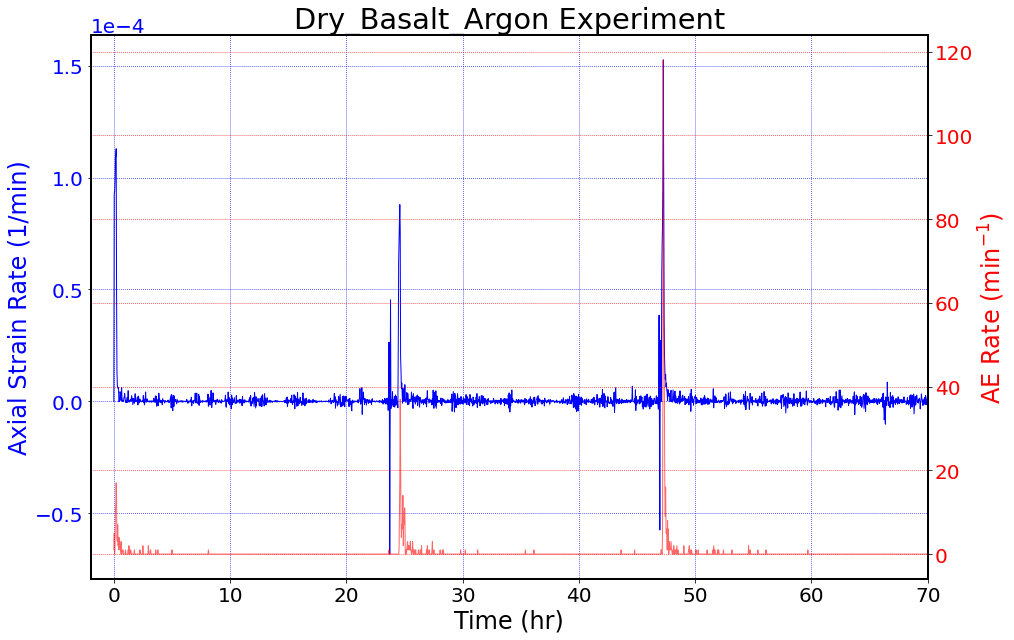

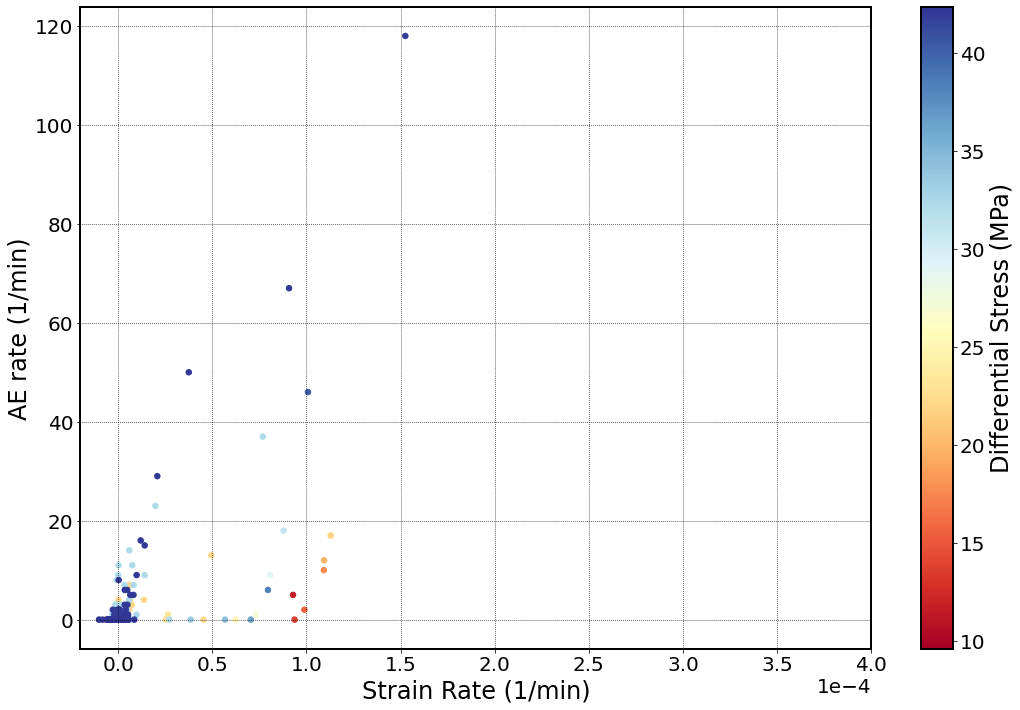

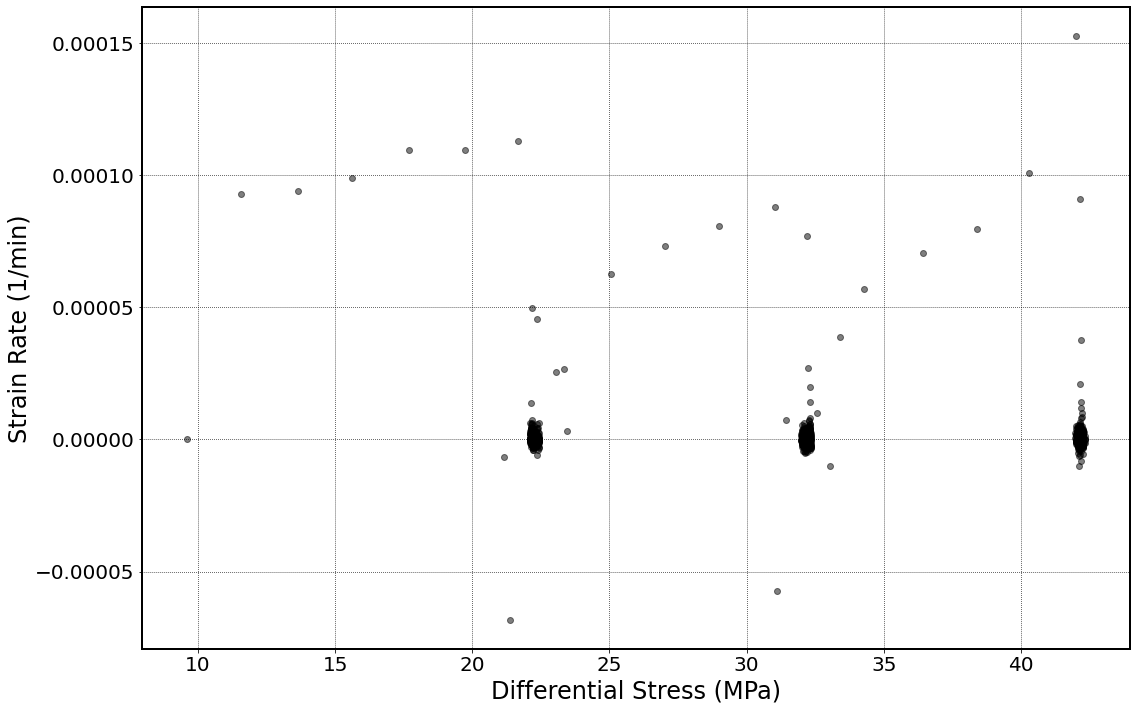

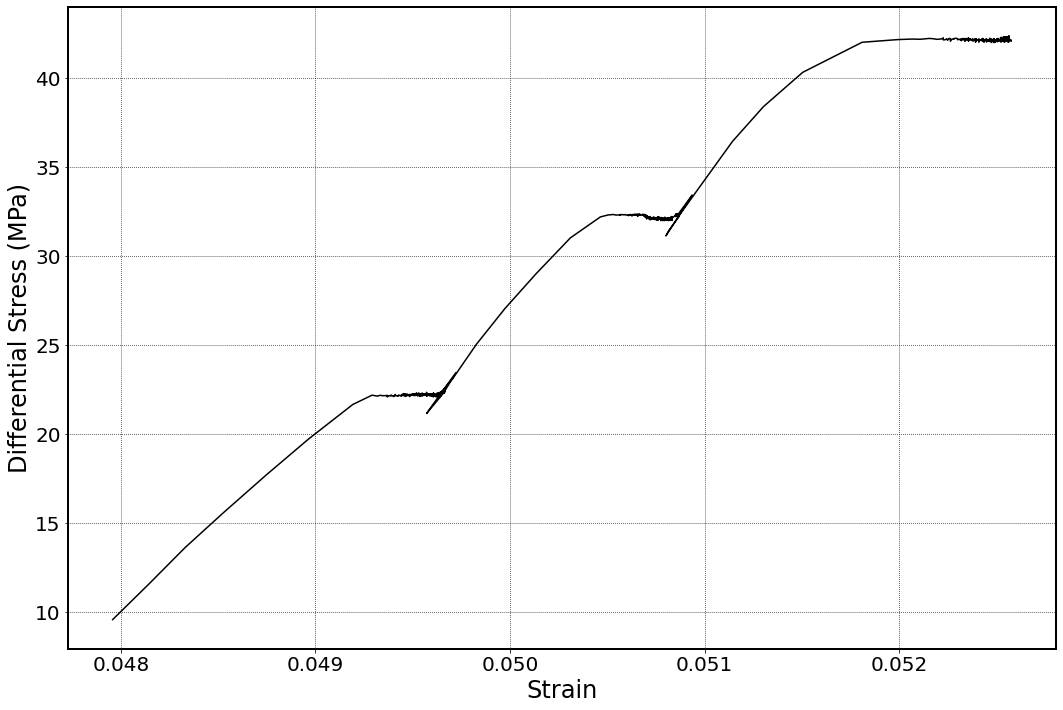

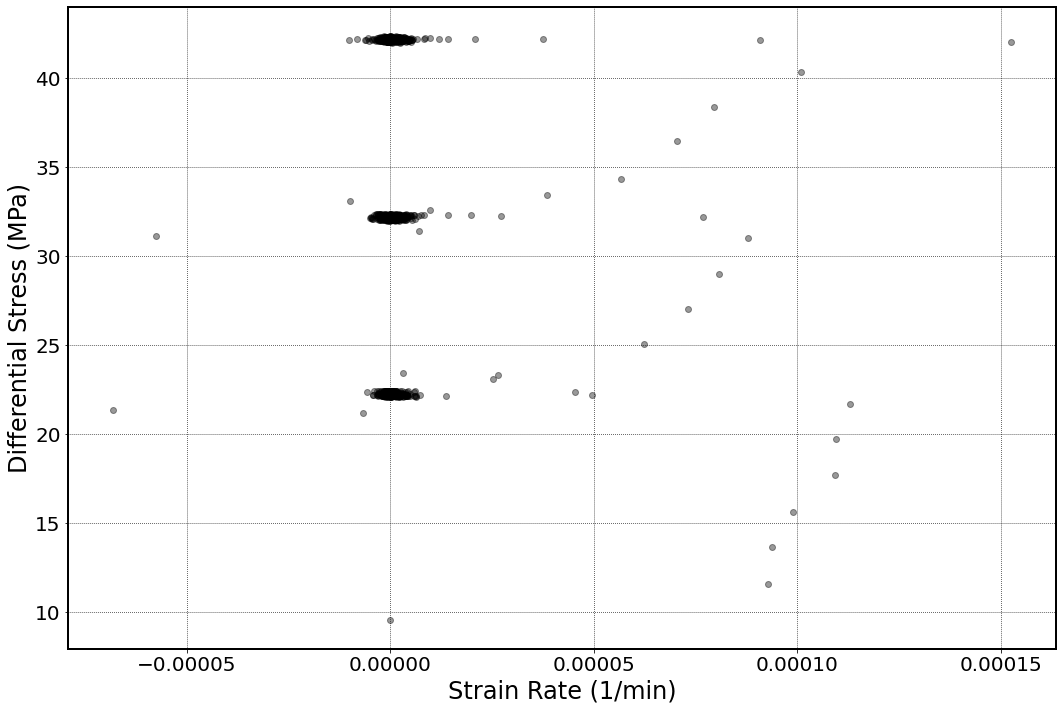

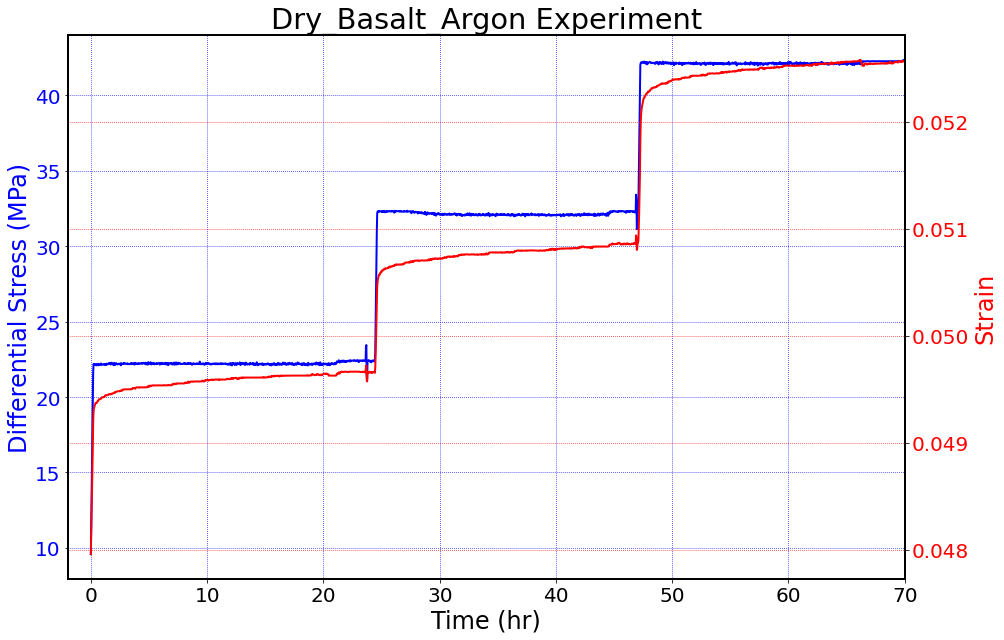

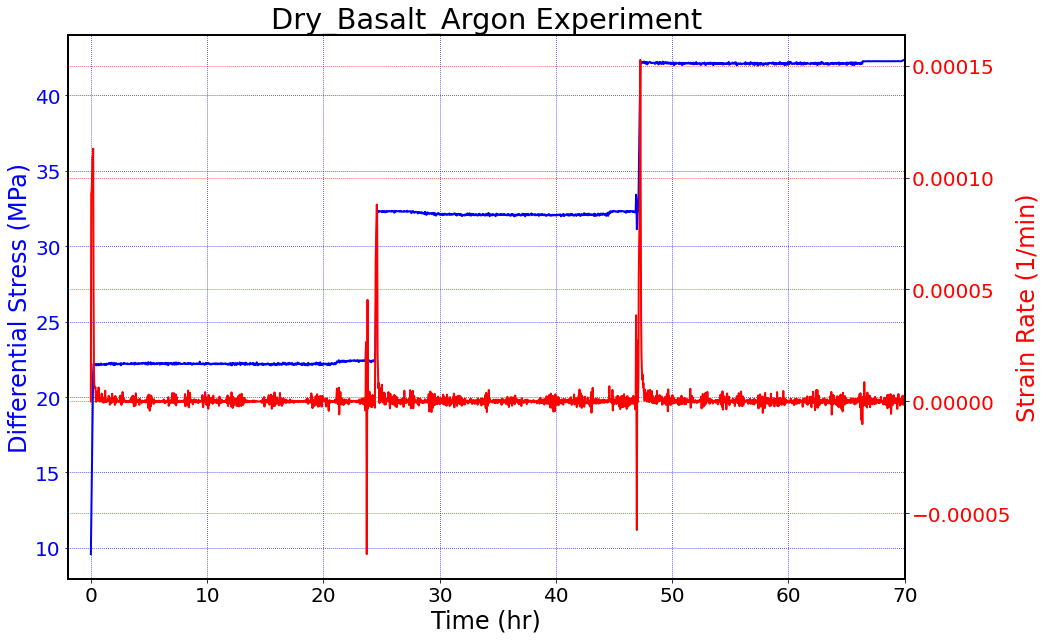

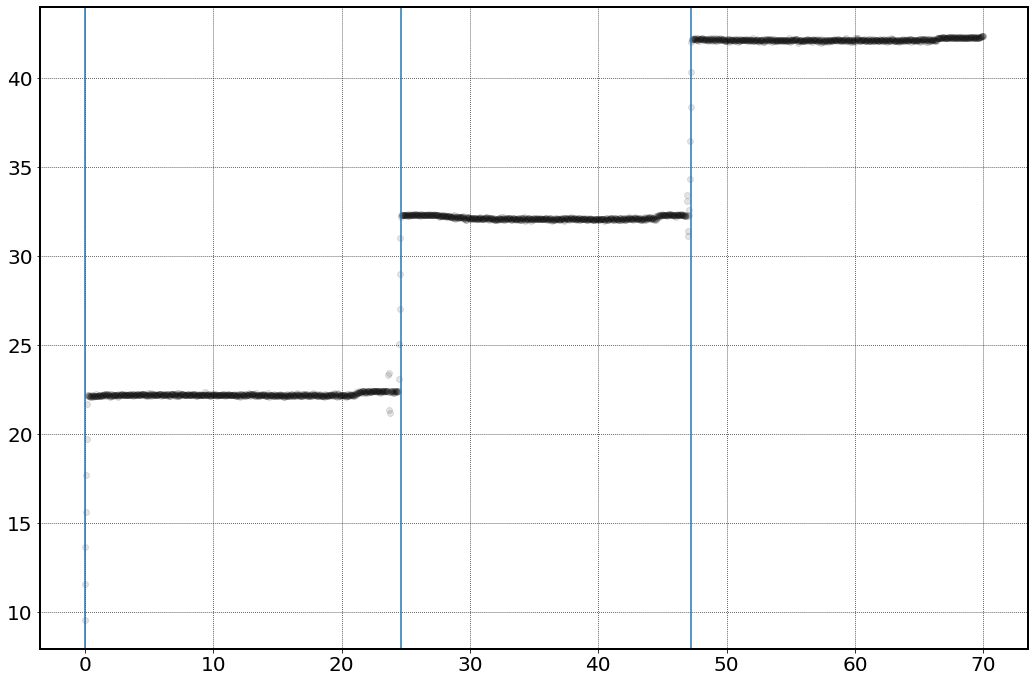

In [61]:
time_window = 120
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=70.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,Temperature=False,max_val=70)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt_Argon Exists
Index value for the stress steps:  [  1   4 493 945]
Time(hr) for the stress steps:  [ 0.04958333 24.64958333 47.24958333]


45657

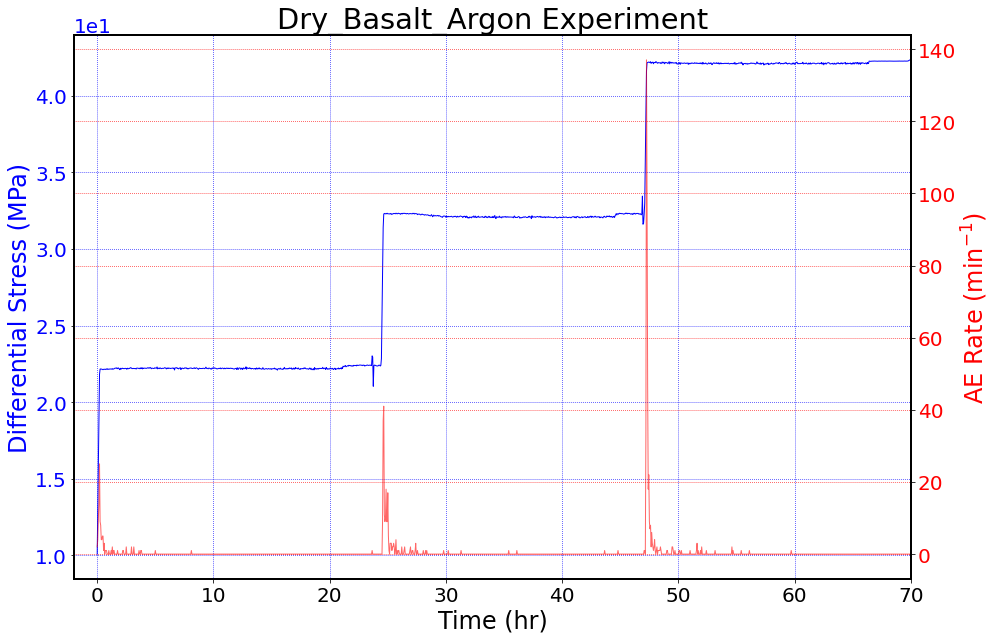

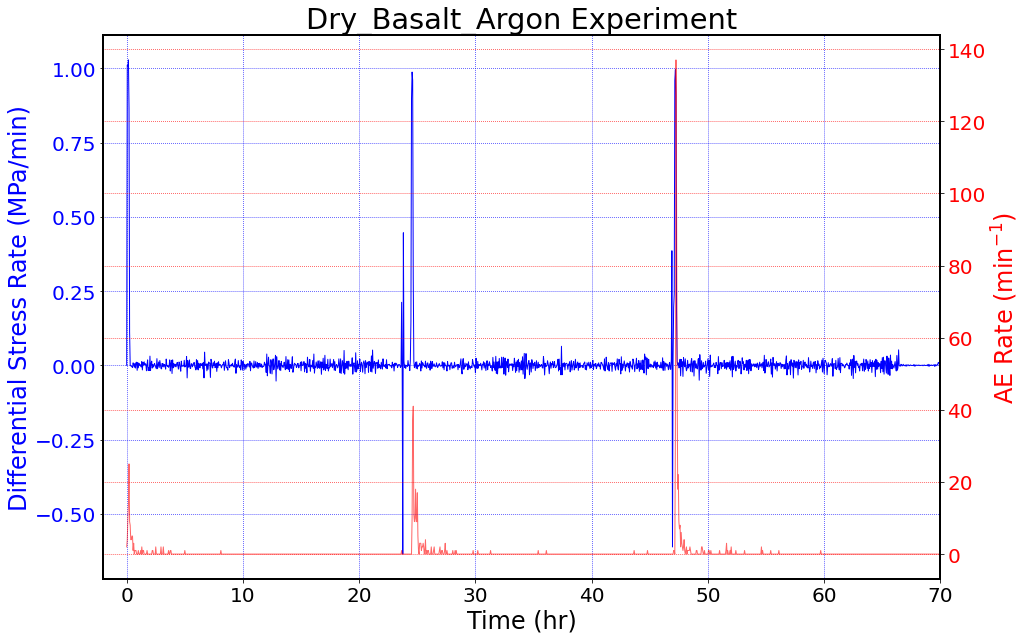

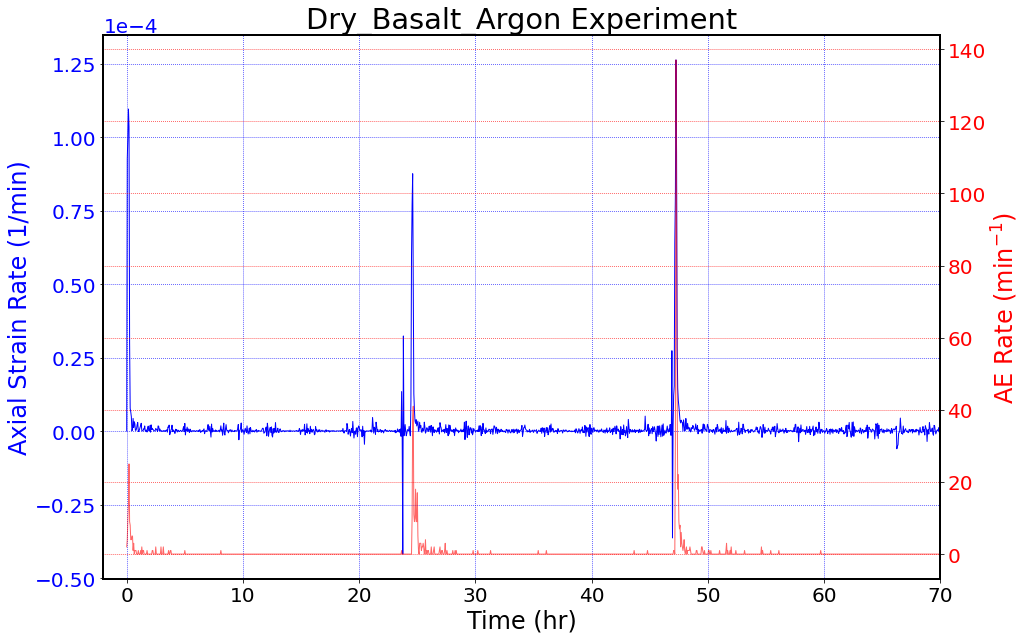

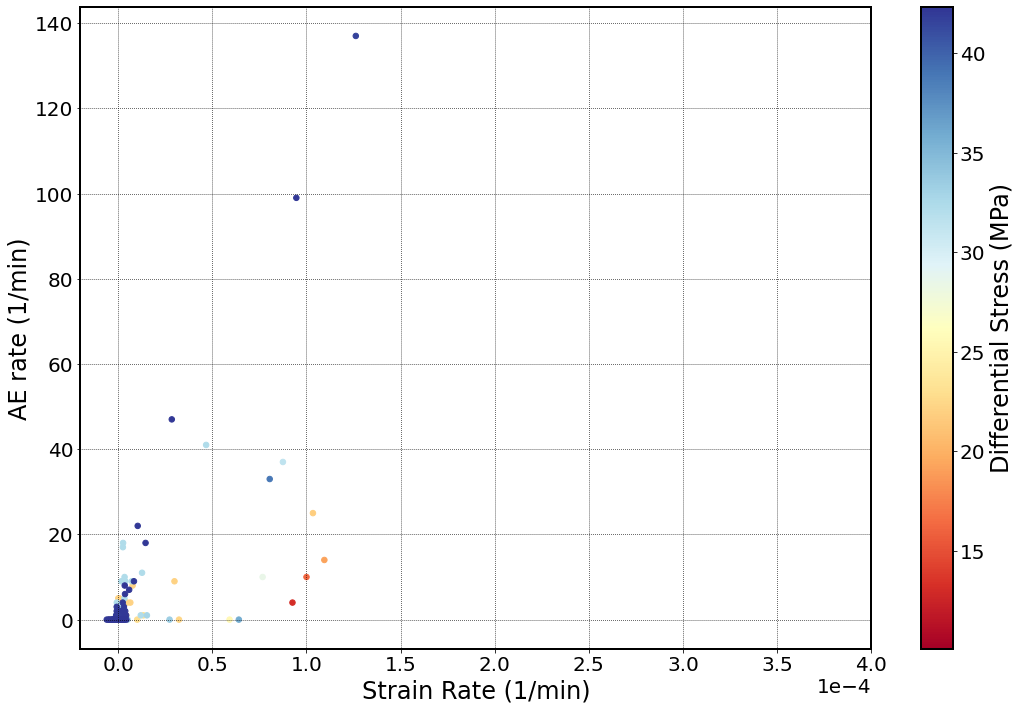

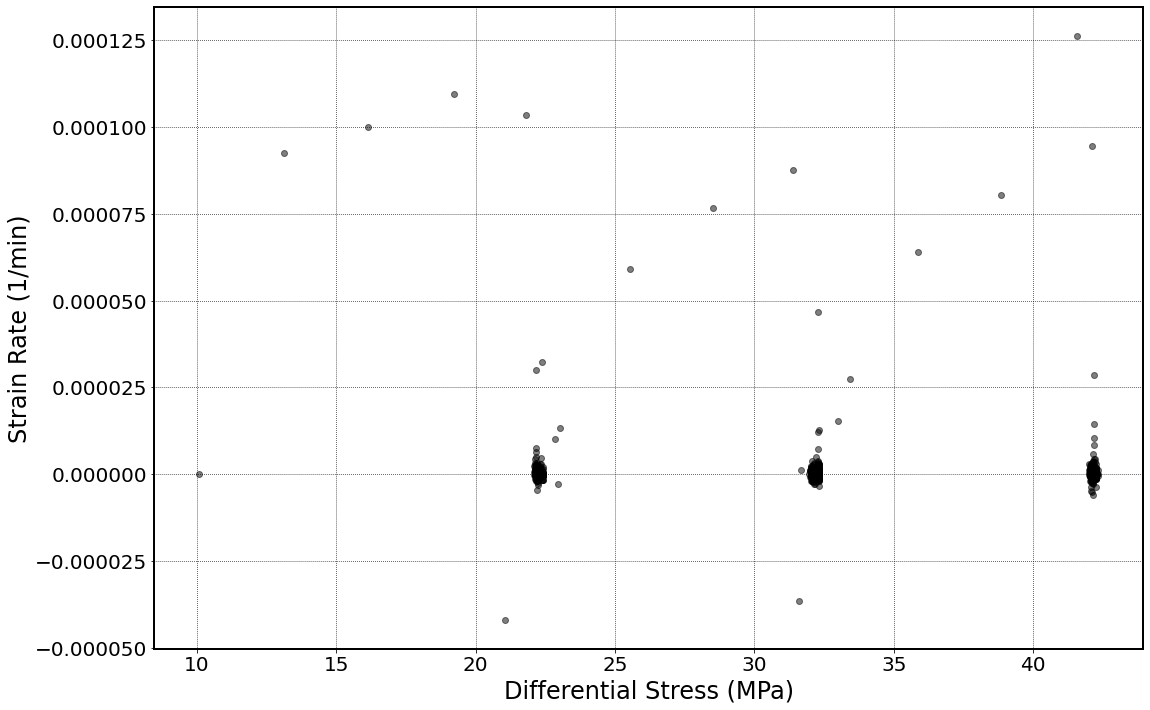

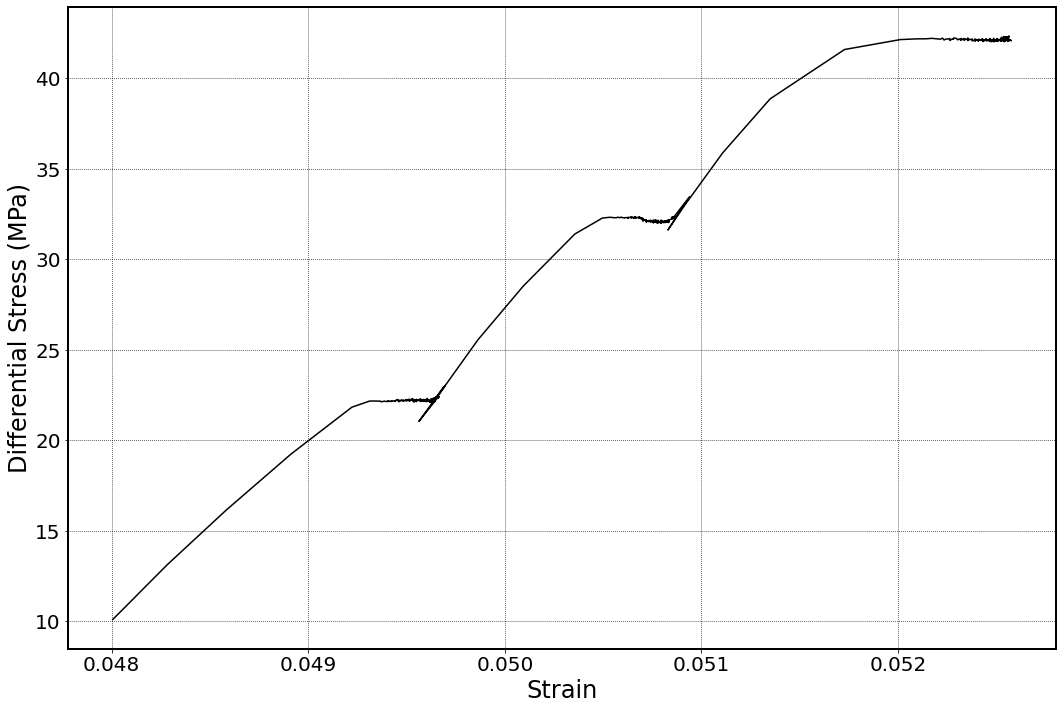

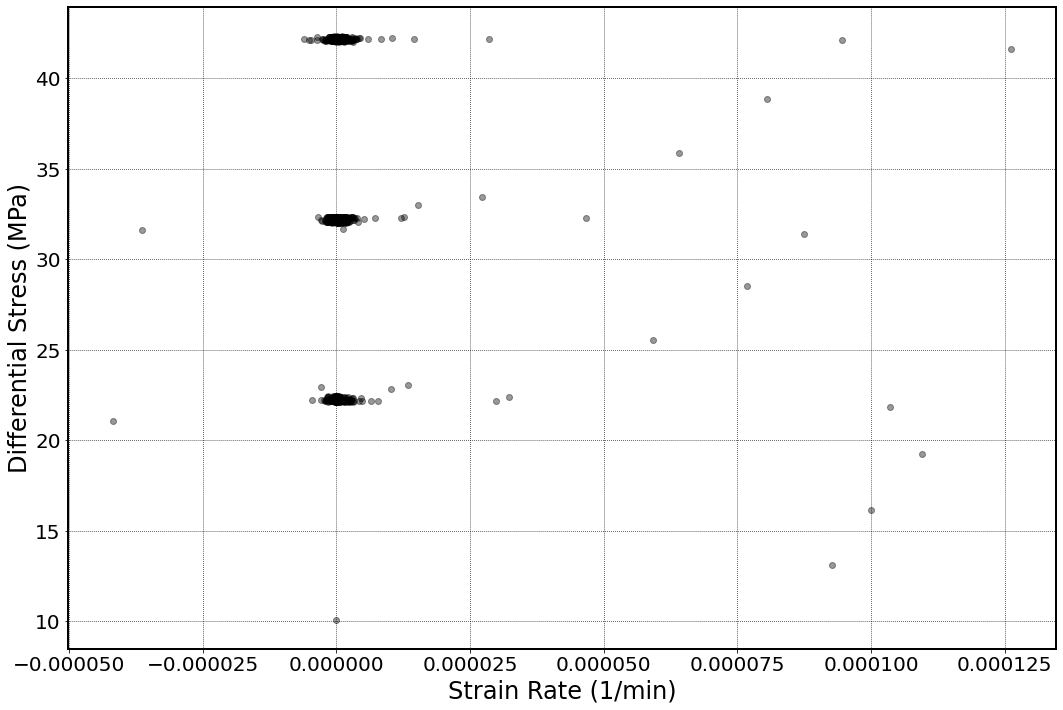

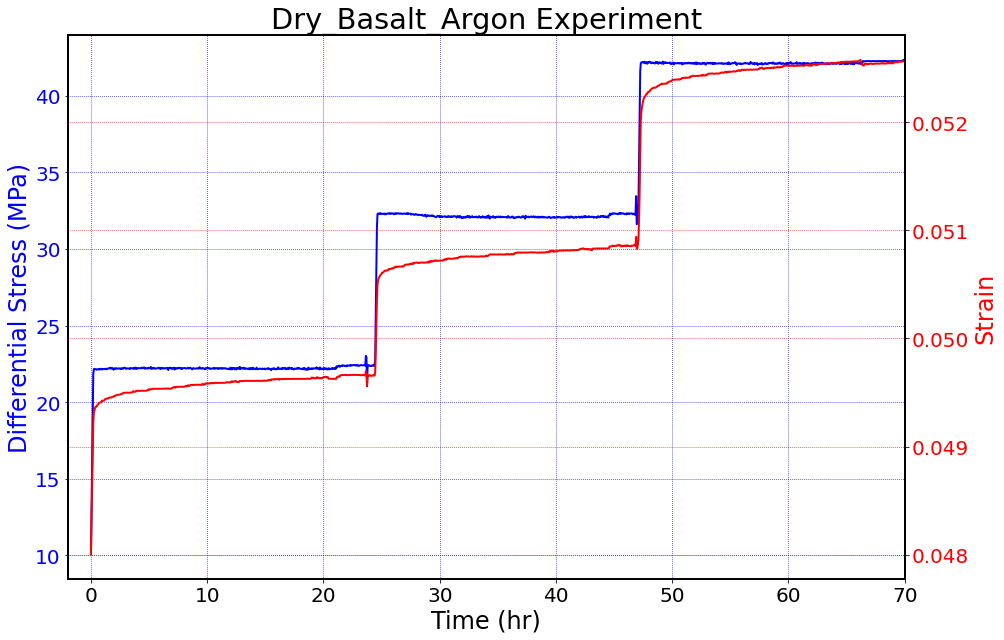

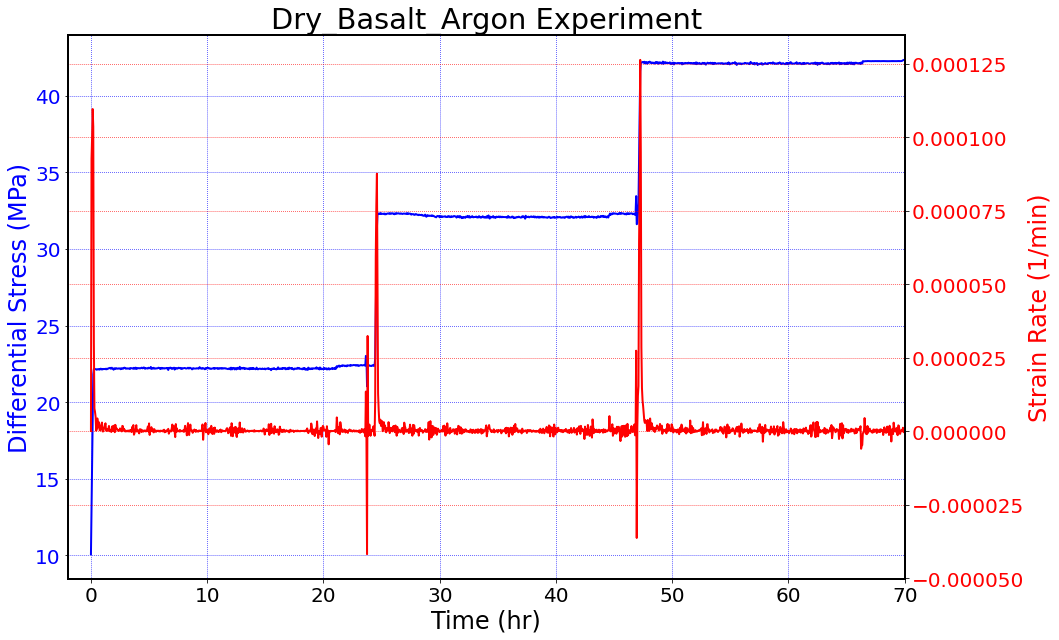

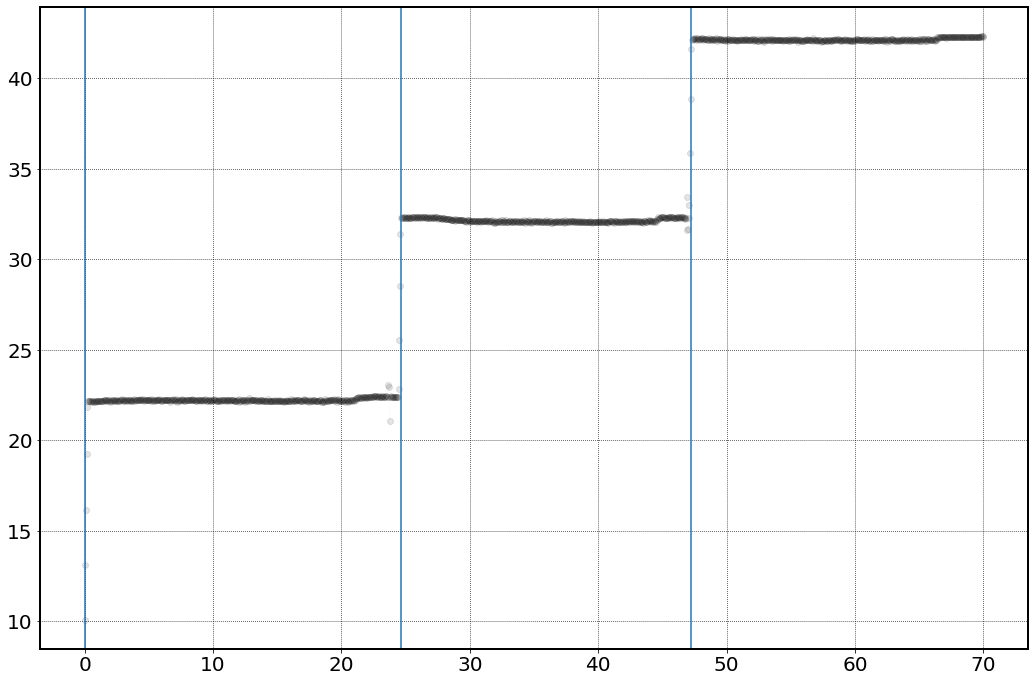

In [62]:
time_window = 180
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=70.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,Temperature=False,max_val=70)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt_Argon Exists
Index value for the stress steps:  [  1   3 296 567]
Time(hr) for the stress steps:  [ 0.08291667 24.66625    47.24958333]


46632

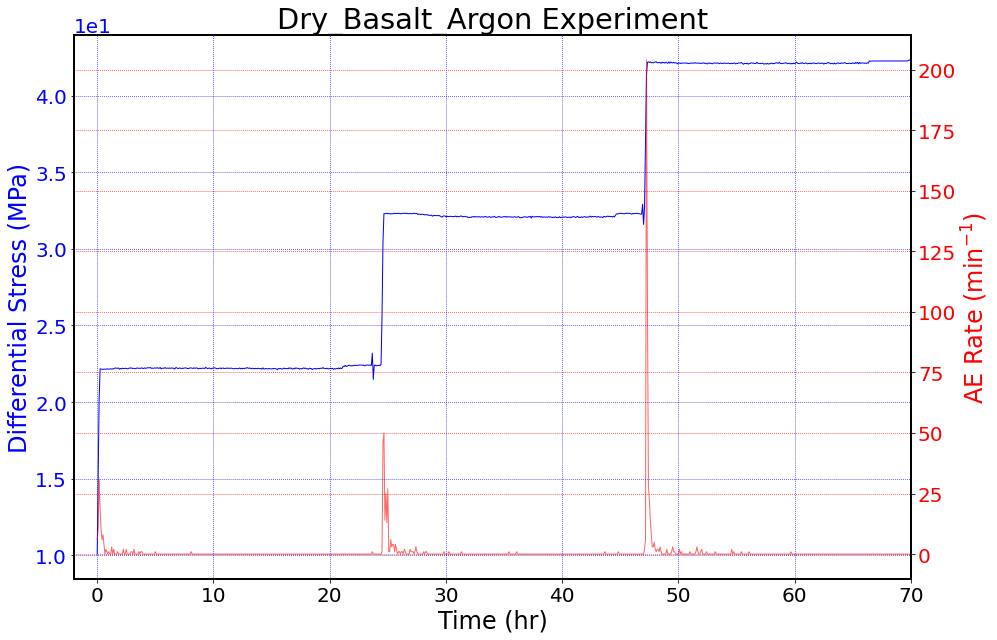

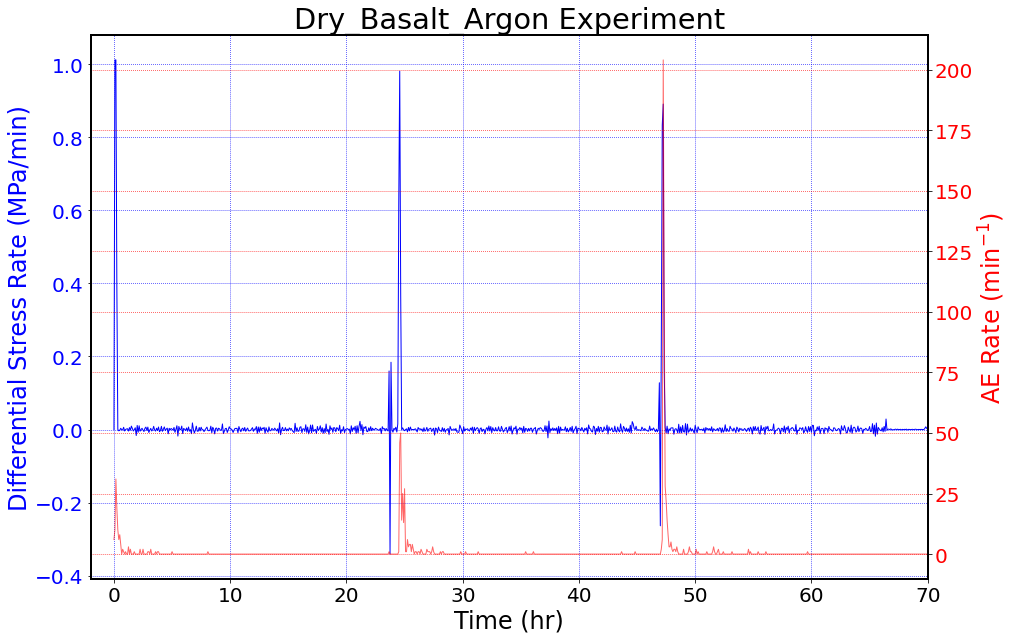

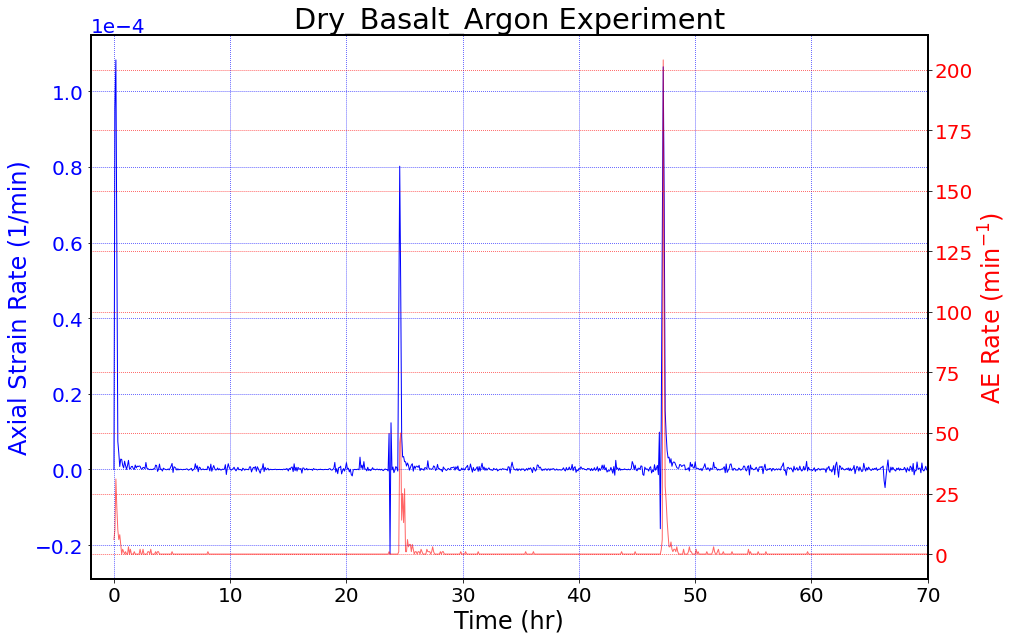

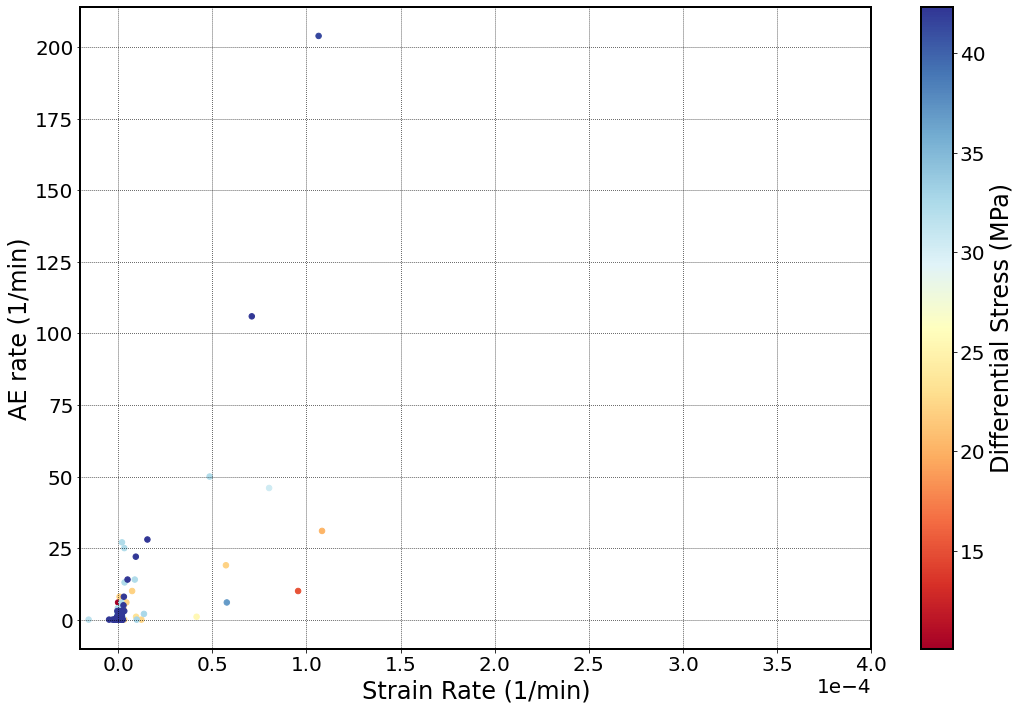

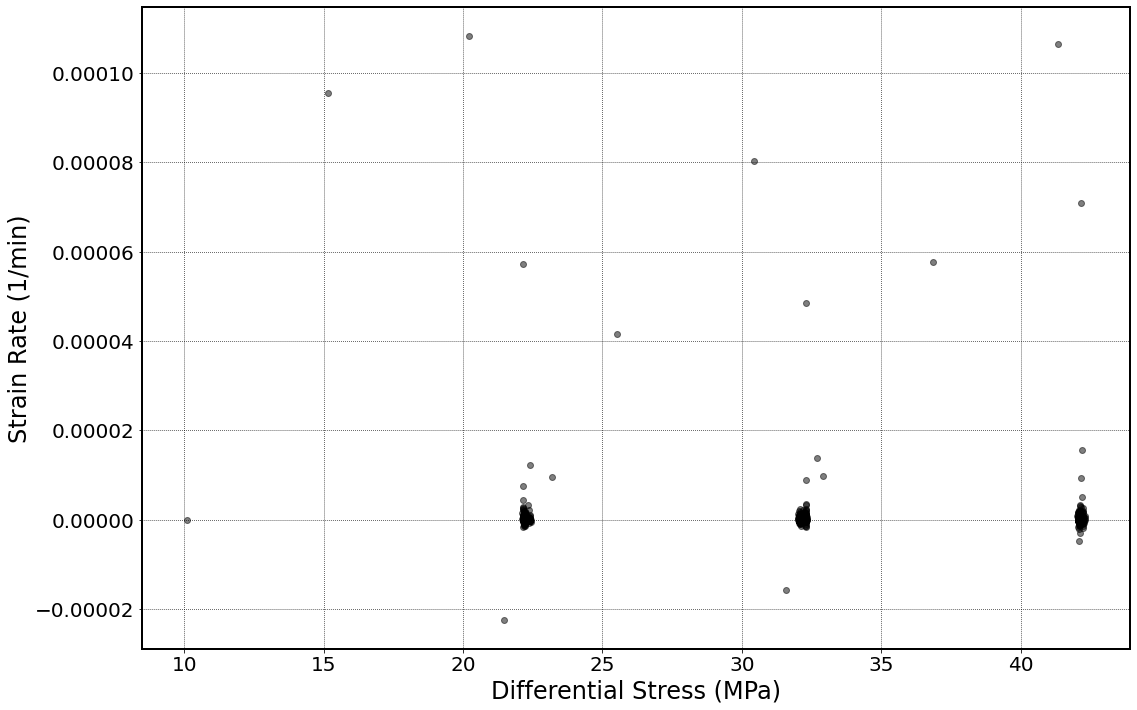

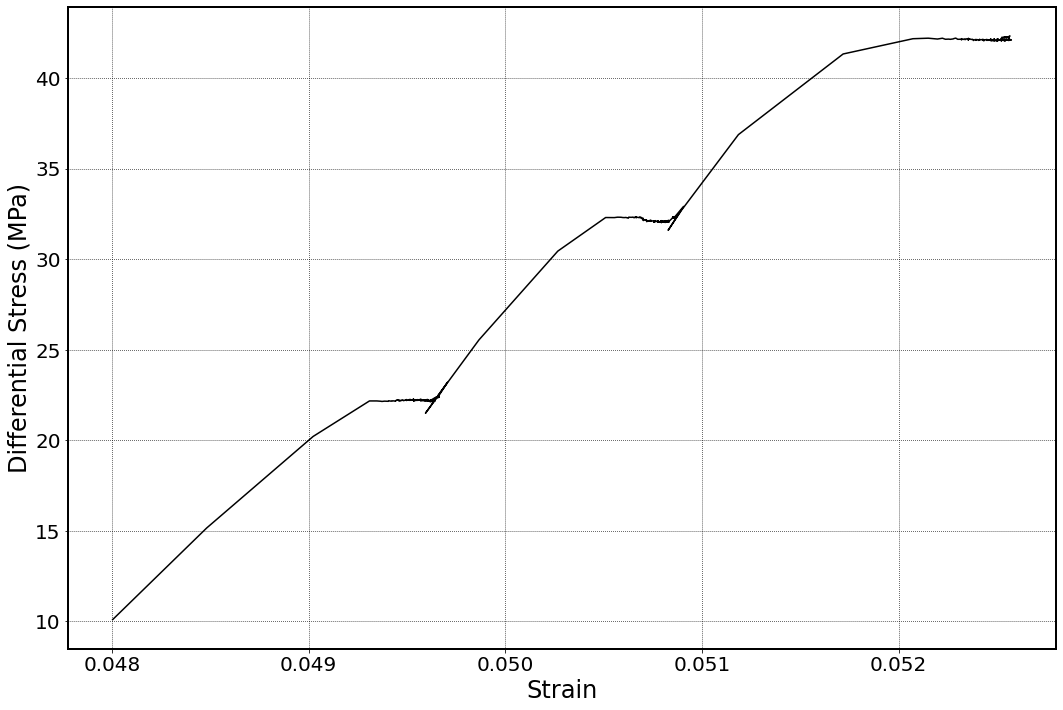

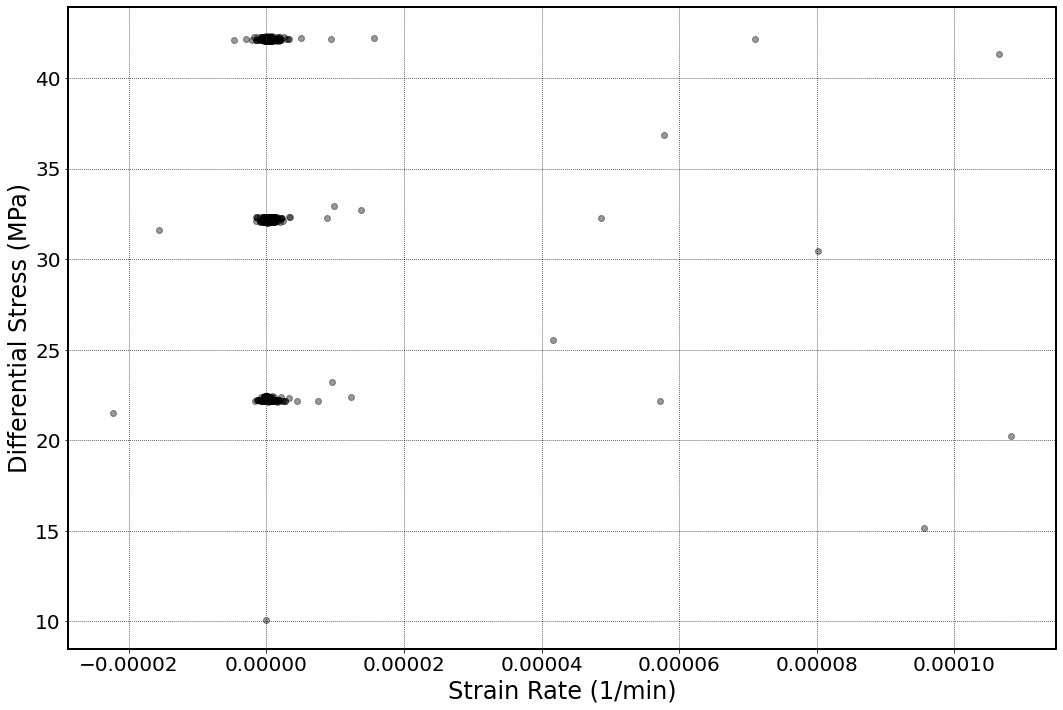

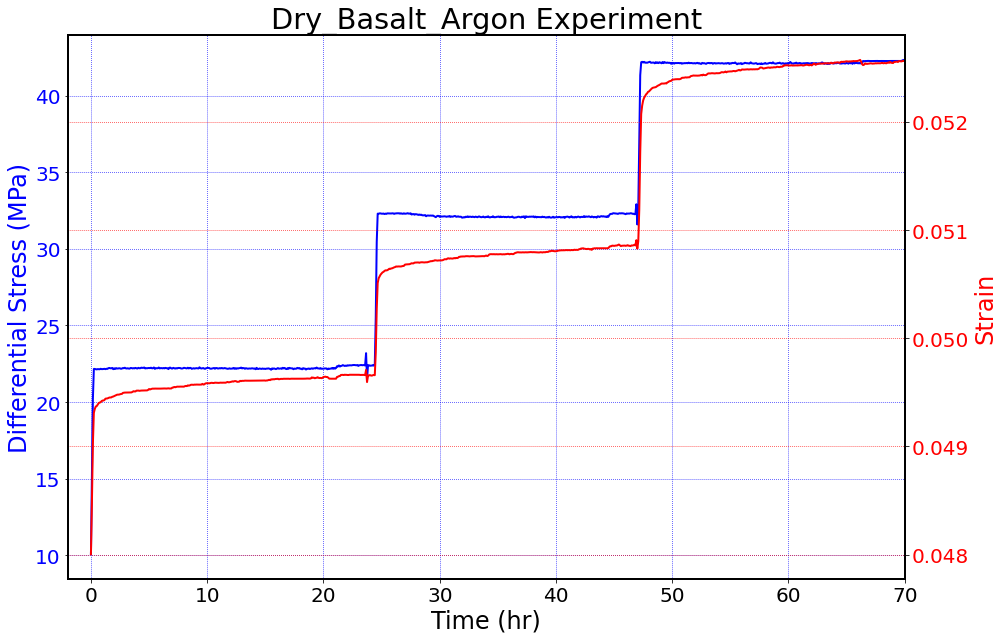

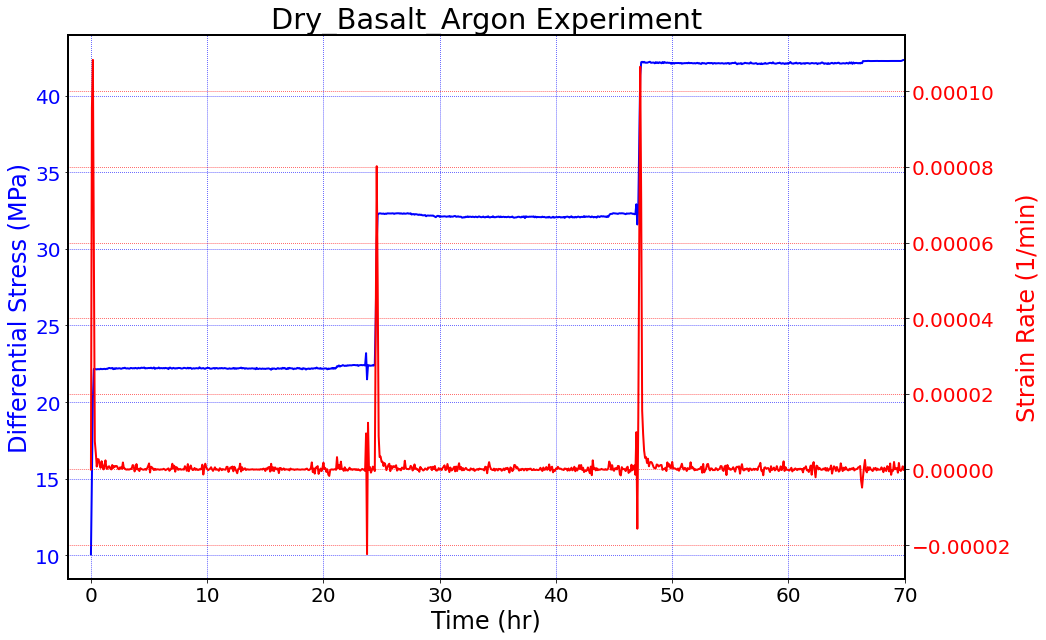

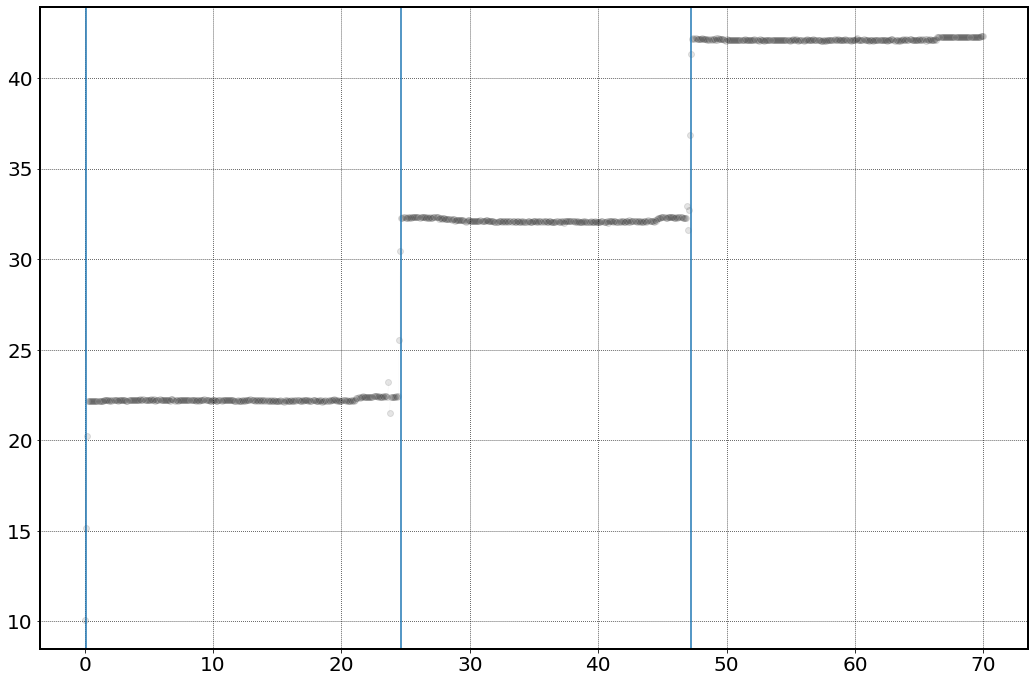

In [63]:
time_window = 300
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=70.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,Temperature=False,max_val=70)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()


Index(['Disp_mm', 'Sig_diff_MPa', 't_def', 'Strain_ax', 'time_hr',
       'AE_rate_count', 'strain_rate', 'stress_rate', 'AE_rate_count_rate',
       'Sig_AE_rate', 'strain_rate_AE_rate', 'strain_AE_rate', 'Sig_strain',
       'Sig_strain_rate', 'Strain_strain_rate'],
      dtype='object')
Output_Plots Exists
Output_Plots/Dry_Basalt_Argon Exists
Index value for the stress steps:  [  1   2 148 284]
Time(hr) for the stress steps:  [ 0.12458333 24.62458333 47.29125   ]


46679

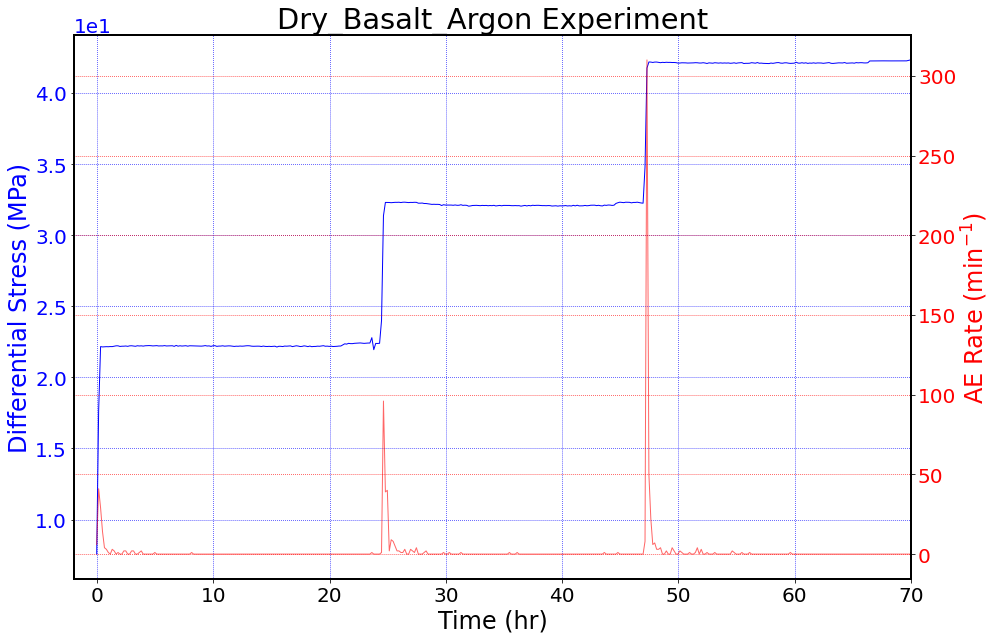

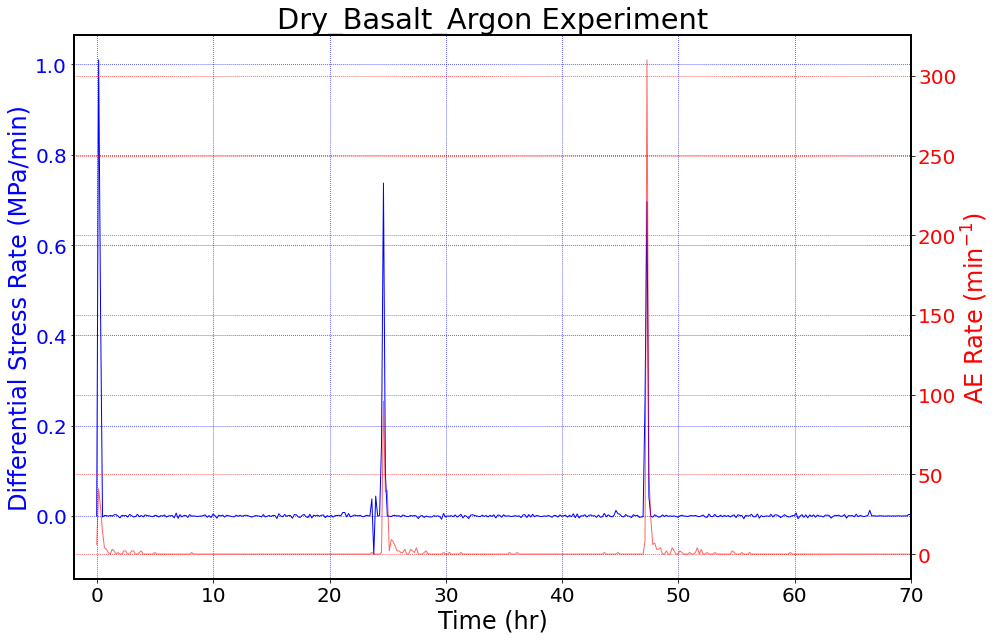

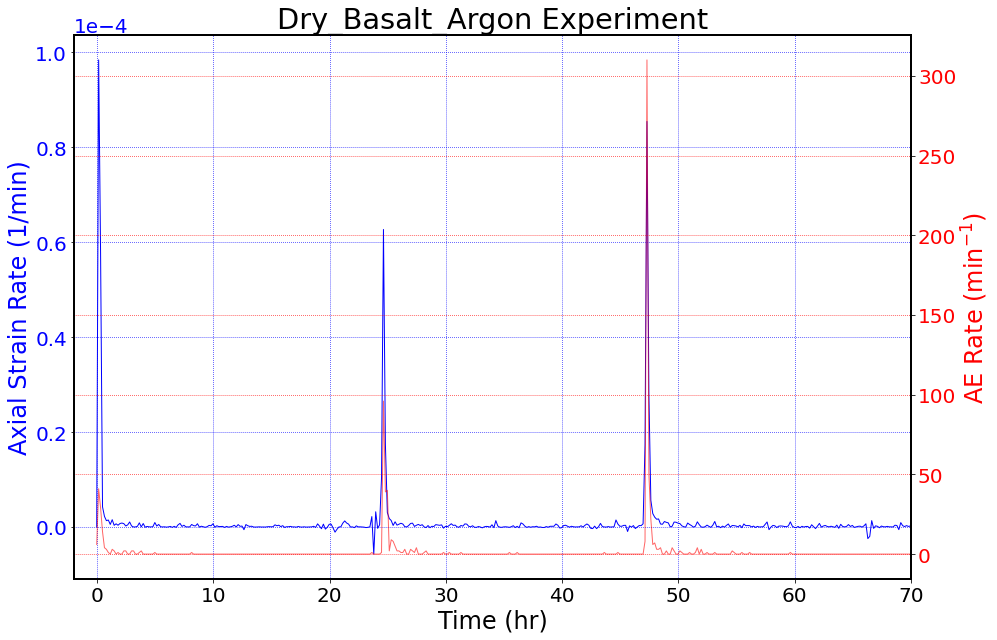

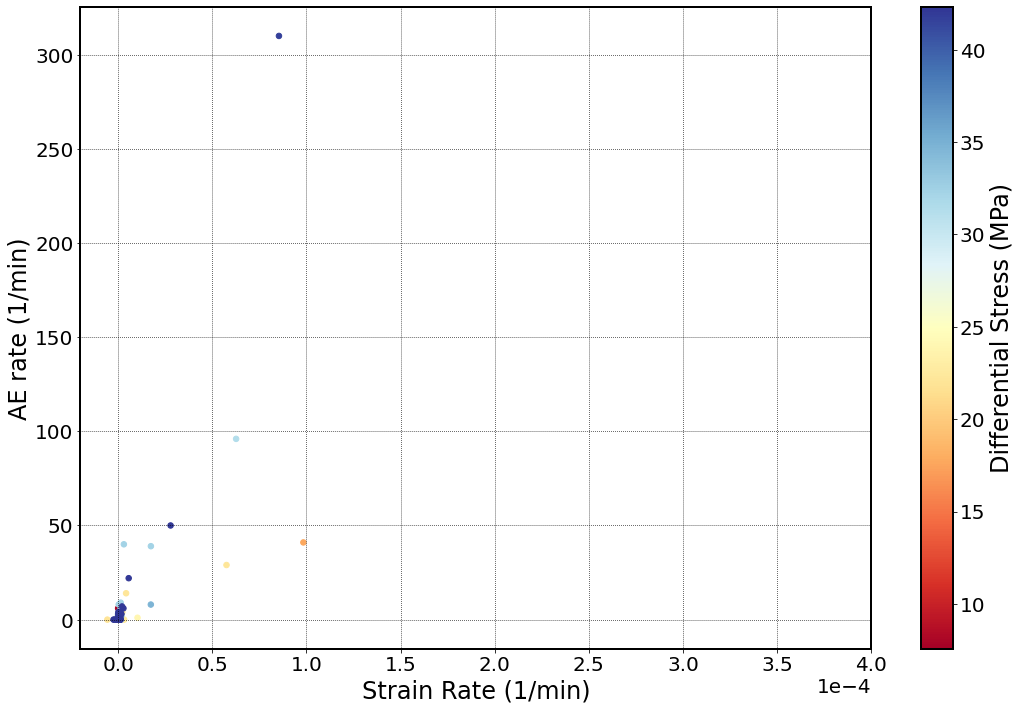

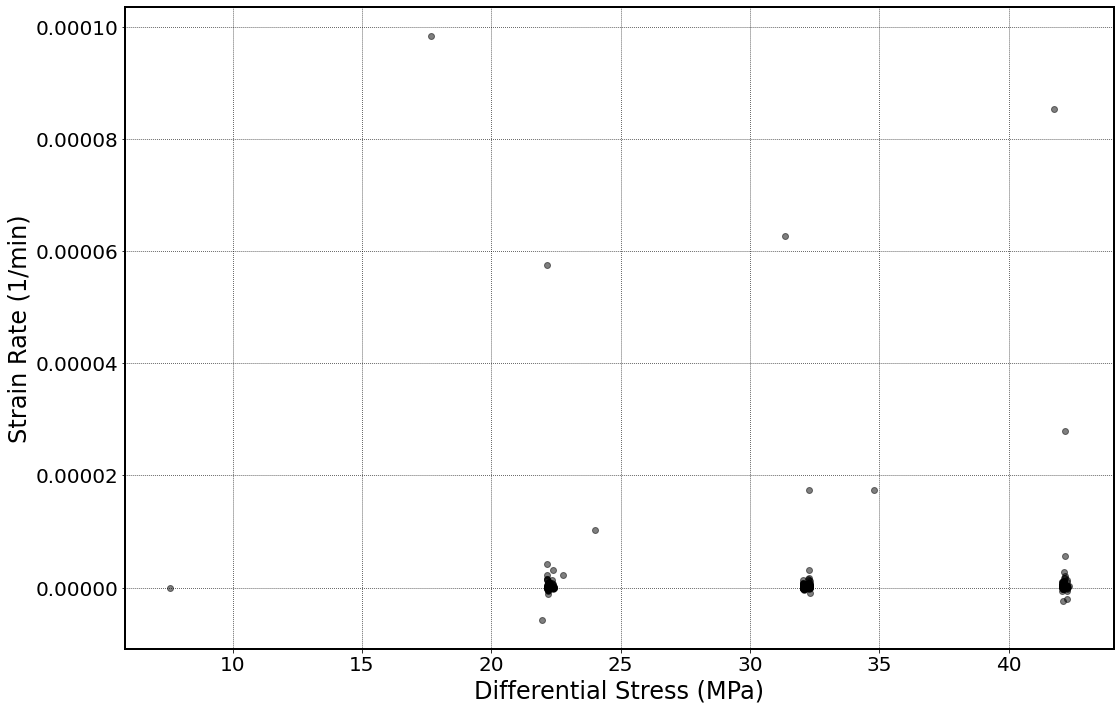

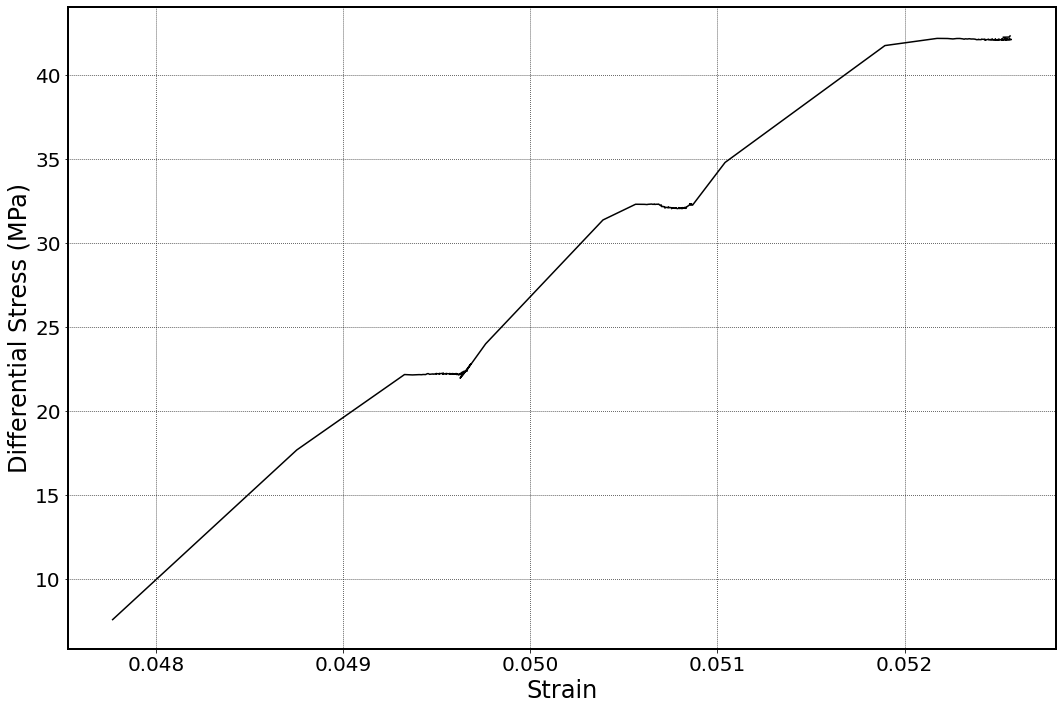

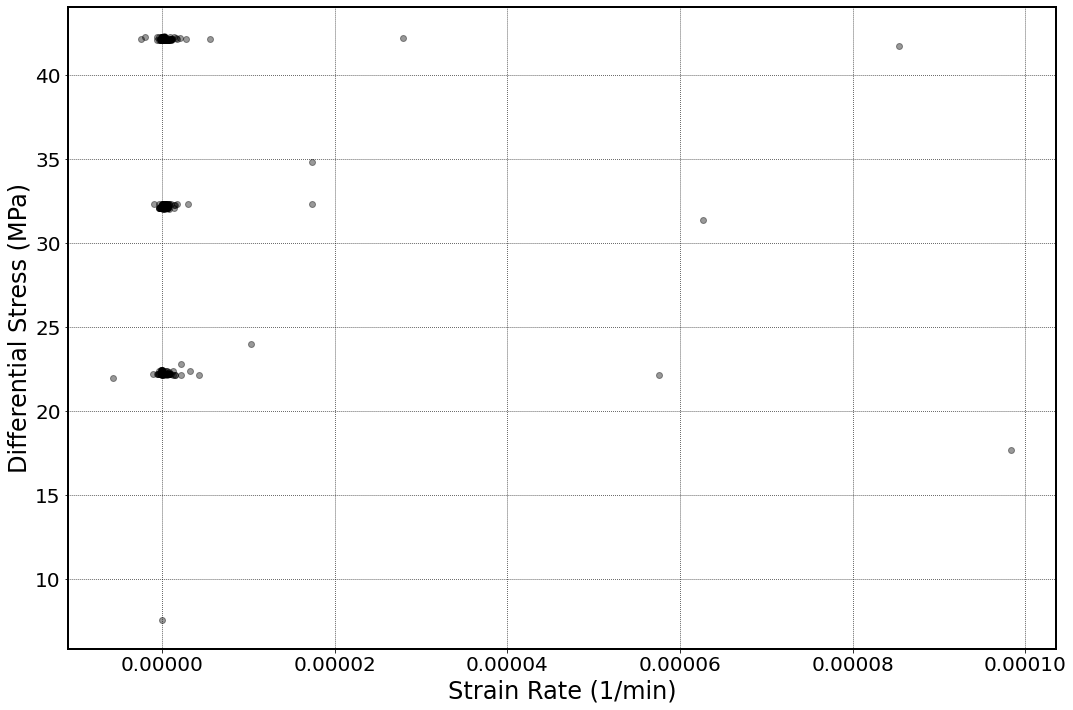

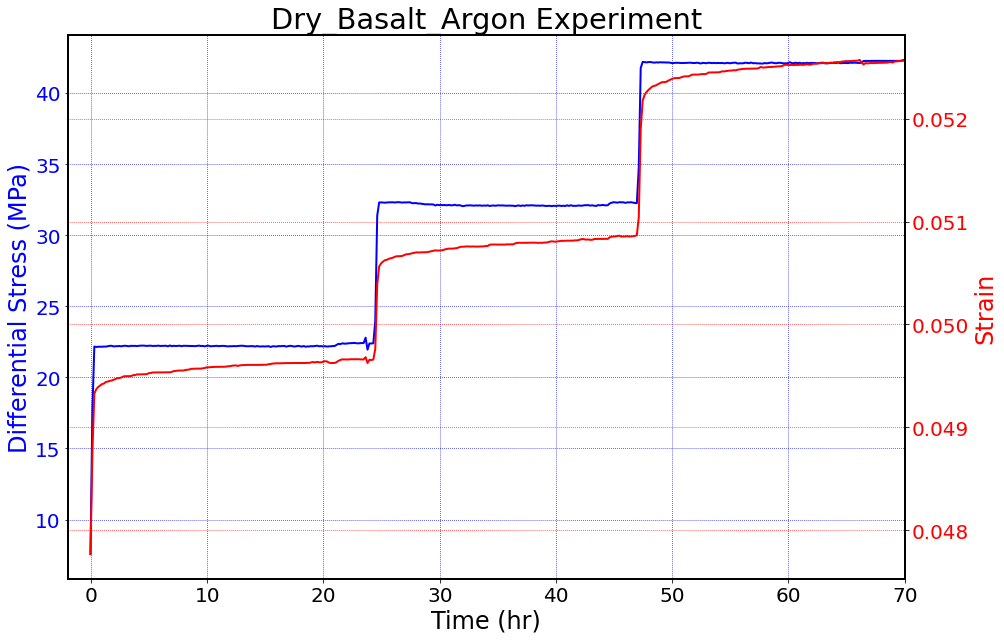

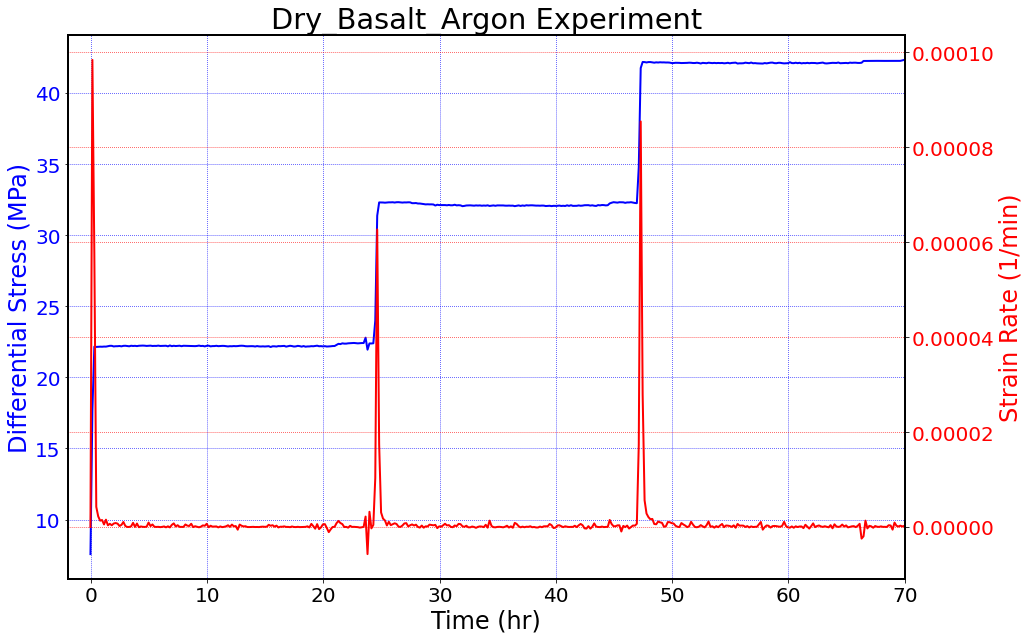

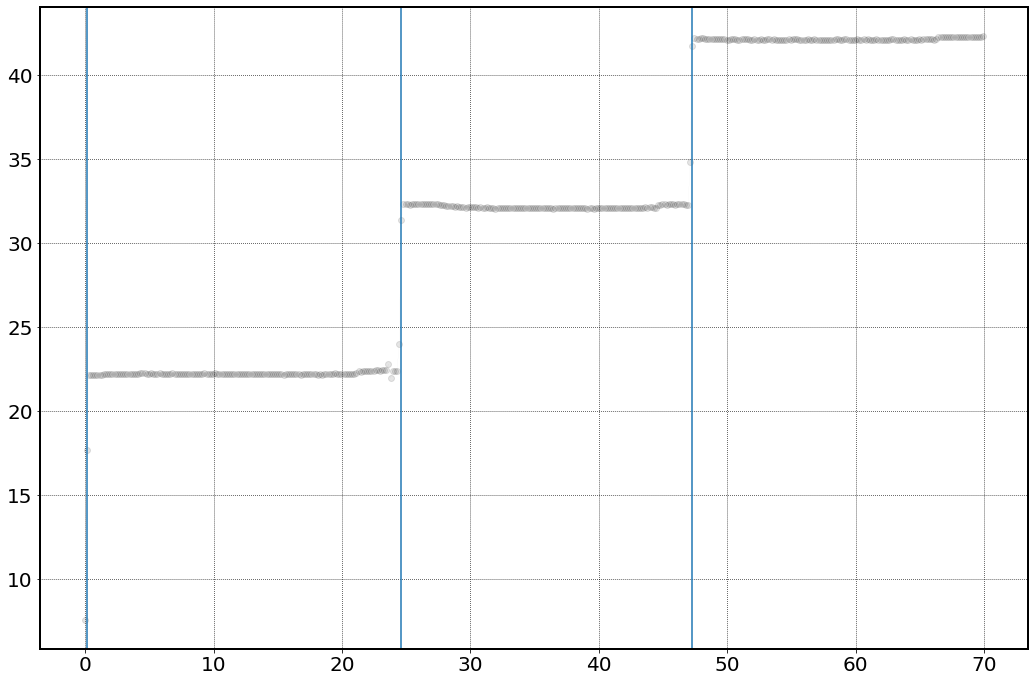

In [64]:
time_window = 600
time_agg = str(int(time_window/60)) + 'min'
new_data_def_Sampl = hbasic.generate_data(new_data,new_data_def,time_window,start_date,end_date)
print(new_data_def_Sampl.columns)
   
new_data_def_Sampl = new_data_def_Sampl.loc[new_data_def_Sampl['time_hr']<=70.,:]
hbasic.make_plots_exp_Dataset(new_data_def_Sampl,name_exp,time_window,Temperature=False,max_val=70)

### Finding the steps in the stress based on stress rate
grad_stress = new_data_def_Sampl['stress_rate']
pot_steps = np.where(grad_stress>0.25)[0]
indx = np.hstack([0,np.where(np.diff(new_data_def_Sampl.time_hr[pot_steps])>5)[0],-1])
print('Index value for the stress steps: ' ,pot_steps[indx])
indx = np.hstack([indx[0],indx[2:]])
time_steps = new_data_def_Sampl.time_hr[pot_steps[indx]].reset_index(drop=True)
print('Time(hr) for the stress steps: ',time_steps.values)

plt.figure()
plt.plot(new_data_def_Sampl.time_hr,new_data_def_Sampl.Sig_diff_MPa,'-ko',linewidth=0.1,alpha=0.1)
for k in pot_steps[indx]:
    plt.axvline(x=new_data_def_Sampl.time_hr[k])

    
# import gc
# gc.collect()

scaled_data1 = MinMaxScaler().fit_transform(new_data_def_Sampl)
scaled_data2 = RobustScaler().fit_transform(new_data_def_Sampl)

hbasic.make_file(new_data_def_Sampl,scaled_data1,path_save_file+'MinMax')
hbasic.make_file(new_data_def_Sampl,scaled_data2,path_save_file+'Robust')
del new_data_def_Sampl;

gc.collect()
